In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA, KernelPCA

from sklearn.cluster import KMeans

from inspect import signature

In [3]:
# Global plot styling adjustments

plt.style.use('seaborn')
plt.rcParams.update({'figure.figsize': (10, 4)}) # Make figure size larger

#### Setting up a custom global n_jobs parameter for ease of use
Set to whichever value works best for you and your processor

In [4]:
n_jobs_custom=12

# Predicting whether an asteroid is Hazardous or Not

## Supervised binary classification

### Author: Kristiyan Bonev

### Summary

The goal of this reserach is to predict if an asteroid is on a collision course with planet Earth.

### Introduction
The dataset used for the purposes of this research is [NASA's JLP Asteroid Dataset](https://www.kaggle.com/sakhawat18/asteroid-dataset).

We will train, tune and evaluate a number of machine learning algorithms (Logistic Regression, Random Forests, AdaBoost) but first let's take a look at the data itself.

# 1. Exploring and configuring the dataset 


### Basic Column Definition

- SPK-ID: Object primary SPK-ID
- Object ID: Object internal database ID
- Object fullname: Object full name/designation
- pdes: Object primary designation
- name: Object IAU name
- NEO: Near-Earth Object (NEO) flag
- PHA: Potentially Hazardous Asteroid (PHA) flag
- H: Absolute magnitude parameter
- Diameter: object diameter (from equivalent sphere) km Unit
- Albedo: Geometric albedo
- Diameter_sigma: 1-sigma uncertainty in object diameter km Unit
- Orbit_id: Orbit solution ID
- Epoch: Epoch of osculation in modified Julian day form
- Equinox: Equinox of reference frame
- e: Eccentricity
- a: Semi-major axis au Unit
- q: perihelion distance au Unit
- i: inclination; angle with respect to x-y ecliptic plane
- tp: Time of perihelion passage TDB Unit
- moid_ld: Earth Minimum Orbit Intersection Distance au Unit

## 1.1 First look

In [5]:
# Reading the dataset

asteroid_data = pd.read_csv("data/NASA JPL Asteroid Dataset.csv")

C:\Users\ksbon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
asteroid_data.head()

,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [7]:
asteroid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              958524 non-null  object 
 1   spkid           958524 non-null  int64  
 2   full_name       958524 non-null  object 
 3   pdes            958524 non-null  object 
 4   name            22064 non-null   object 
 5   prefix          18 non-null      object 
 6   neo             958520 non-null  object 
 7   pha             938603 non-null  object 
 8   H               952261 non-null  float64
 9   diameter        136209 non-null  float64
 10  albedo          135103 non-null  float64
 11  diameter_sigma  136081 non-null  float64
 12  orbit_id        958524 non-null  object 
 13  epoch           958524 non-null  float64
 14  epoch_mjd       958524 non-null  int64  
 15  epoch_cal       958524 non-null  float64
 16  equinox         958524 non-null  object 
 17  e         

There is a high number of null values in some columns which will get in the way and will need to be cleaned up.

In [8]:
asteroid_data.describe()

,spkid,H,diameter,albedo,diameter_sigma,epoch,epoch_mjd,epoch_cal,e,a,...,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,rms
count,9.585240e+05,952261.000000,136209.000000,135103.000000,136081.000000,9.585240e+05,958524.000000,9.585240e+05,958524.000000,958524.000000,...,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.386020e+05,9.385980e+05,9.386020e+05,9.386020e+05,9.385980e+05,958522.000000
mean,3.810114e+06,16.906411,5.506429,0.130627,0.479184,2.458869e+06,58868.781950,2.019693e+07,0.156116,2.902143,...,1.982929e+01,1.168449e+00,5.310234e+00,1.370062e+06,1.369977e+06,2.131453e+01,5.060221e-02,4.312780e+08,8.525815e+04,0.561153
std,6.831541e+06,1.790405,9.425164,0.110323,0.782895,7.016716e+02,701.671573,1.930354e+04,0.092643,39.719503,...,2.903785e+03,1.282231e+02,1.333381e+03,9.158996e+08,9.158991e+08,7.197034e+03,9.814953e+00,2.953046e+11,2.767681e+07,2.745700
min,2.000001e+06,-1.100000,0.002500,0.001000,0.000500,2.425052e+06,25051.000000,1.927062e+07,0.000000,-14702.447872,...,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,0.000000
25%,2.239632e+06,16.100000,2.780000,0.053000,0.180000,2.459000e+06,59000.000000,2.020053e+07,0.092193,2.387835,...,1.462000e-07,6.095900e-06,3.619400e-05,5.755000e-05,2.573700e-05,2.340900e-08,2.768800e-09,1.110900e-04,1.794500e-05,0.518040
50%,2.479262e+06,16.900000,3.972000,0.079000,0.332000,2.459000e+06,59000.000000,2.020053e+07,0.145002,2.646969,...,2.271900e-07,8.688800e-06,6.642550e-05,1.047100e-04,4.900100e-05,4.359000e-08,4.638000e-09,2.230800e-04,3.501700e-05,0.566280
75%,3.752518e+06,17.714000,5.765000,0.190000,0.620000,2.459000e+06,59000.000000,2.020053e+07,0.200650,3.001932,...,6.583200e-07,1.591500e-05,1.609775e-04,3.114400e-04,1.718900e-04,1.196600e-07,1.124000e-08,8.139600e-04,9.775475e-05,0.613927
max,5.401723e+07,33.200000,939.400000,1.000000,140.000000,2.459000e+06,59000.000000,2.020053e+07,1.855356,33488.895955,...,1.015000e+06,5.533000e+04,1.199100e+06,8.845100e+11,8.845100e+11,5.509700e+06,7.698800e+03,2.853100e+14,1.910700e+10,2686.600000


Comparing the standard deviation to the min and max values of some features it looks like we might be dealing with some outlier observations.  Examples would be a, e, q, H and sigma.

In [9]:
asteroid_data.nunique()

id                958524
spkid             958524
full_name         958524
pdes              958524
name               22064
prefix                 1
neo                    2
pha                    2
H                   9489
diameter           16591
albedo              1057
diameter_sigma      3054
orbit_id            4690
epoch               5246
epoch_mjd           5246
epoch_cal           5246
equinox                1
e                 958444
a                 958509
q                 958509
i                 958414
om                958518
w                 958519
ma                958519
ad                958505
n                 958514
tp                958519
tp_cal            958499
per               958510
per_y             958511
moid              314300
moid_ld           314301
sigma_e           254740
sigma_a           273297
sigma_q           248138
sigma_i           215741
sigma_om          223155
sigma_w           262719
sigma_ma          266816
sigma_ad          269241


Equinox and prefix have identical values in every observation so they will not be of use. We already saw earlier that prefix has very few no null entries as well. Equinox has no null values but isn't of much use ragerdless.

In [10]:
asteroid_data.isnull().sum()

id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926


A number of columns can safely be removed as they either won't contribute to the performance of the models (ids and names) or just have too many null values(diameter, albedo).

## 1.2 Picking a target

The options I am considering are Near Earth Object(NEO) and Potentially Hazardous Asteroids(PHA)


In [11]:
asteroid_data.neo.unique()

array(['N', 'Y', nan], dtype=object)

In [12]:
asteroid_data.groupby("neo").size()

neo
N    935625
Y     22895
dtype: int64

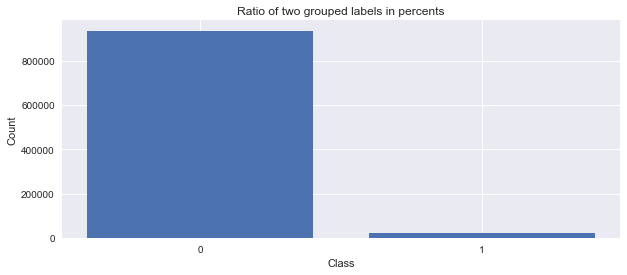

Positive cases: 2.39% of all


In [13]:
# Percent ration of Near Earth Objects

positive_neo = asteroid_data.neo == "Y"
total_neo = len(asteroid_data.neo)

plt.bar([0, 1], [len(asteroid_data[asteroid_data.neo == 'N']), len(asteroid_data[asteroid_data.neo == 'Y'])])
plt.title("Ratio of two grouped labels in percents")
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Positive cases: {:.2f}% of all".format(positive_neo.sum() / total_neo * 100))

In [14]:
asteroid_data.pha.unique()

array(['N', 'Y', nan], dtype=object)

In [15]:
asteroid_data.groupby("pha").size()
#asteroid_data.value_counts("pha")

pha
N    936537
Y      2066
dtype: int64

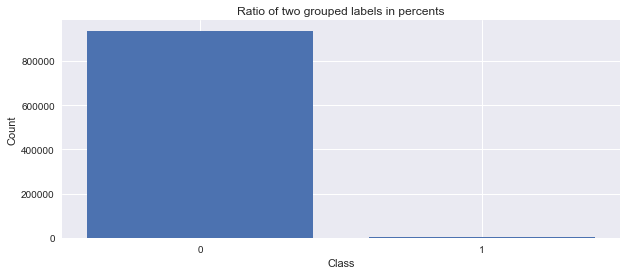

Positive cases: 0.22% of all


In [16]:
# Percent ration of Potentially Hazardous Asteroids

positive_pha = asteroid_data.pha == "Y"
total_pha = len(asteroid_data.pha)

plt.bar([0, 1], [len(asteroid_data[asteroid_data.pha == 'N']), len(asteroid_data[asteroid_data.pha == 'Y'])])
plt.title("Ratio of two grouped labels in percents")
plt.xticks([0, 1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print("Positive cases: {:.2f}% of all".format(positive_pha.sum() / total_pha * 100))

NEO is the safer option as it has about 10 times more positive examples but PHA is the one I am more interested in so I will try and use it as my target.

PHA contains quite a few null values which should be removed as well. The sigma variables also seems to contain the same exact number of null values + 1 which doesn't seem like a coincidence.

## 1.3 Data Preprocessing


Let's start by removing the columns that won't be of any use:

- ####   diameter, albedo, diameter_sigma
These columns mainly contain null values so they can be removed. Some diameter data could be of use but with so few entries it is not of much use. Albedo could also tell us some interesting information about what the asteroid is comprised of (at least on the surface) but again, not many entries to work with.

- #### id, spkid, pdes, orbit_id, full_name, name, prefix
Identification columns are not needed for our purposes so they will be removed as well.

- #### equinox
As mentioned previously, this one has identical value for each entry so it can go as well.

In [17]:
# Removing unwanted columns
asteroid_data = asteroid_data.drop(
    ["name", 
     "prefix", 
     "diameter", 
     "albedo", 
     "diameter_sigma", 
     "id", 
     "spkid", 
     "full_name", 
     "pdes",
     "orbit_id",
     "equinox"
    ], axis = 1)

In [18]:
asteroid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958524 entries, 0 to 958523
Data columns (total 34 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        958520 non-null  object 
 1   pha        938603 non-null  object 
 2   H          952261 non-null  float64
 3   epoch      958524 non-null  float64
 4   epoch_mjd  958524 non-null  int64  
 5   epoch_cal  958524 non-null  float64
 6   e          958524 non-null  float64
 7   a          958524 non-null  float64
 8   q          958524 non-null  float64
 9   i          958524 non-null  float64
 10  om         958524 non-null  float64
 11  w          958524 non-null  float64
 12  ma         958523 non-null  float64
 13  ad         958520 non-null  float64
 14  n          958524 non-null  float64
 15  tp         958524 non-null  float64
 16  tp_cal     958524 non-null  float64
 17  per        958520 non-null  float64
 18  per_y      958523 non-null  float64
 19  moid       938603 non-n

### 1.3.1 Handling Null values

- With PHA as my target I cannot have any null values in so those rows will all be removed;
- H has a decent amout of null values but none correcpond to positive PHA values. Considering that the dataset contain an abundace of negative PHA entries, I believe these ones can safely be removed since it's the most time effecient option;
- NEO, ad, ma, per and rms all have 1-4 rows containing null values but much like H there are no positive corresponding PHA values;


In [19]:
# Removing null values
asteroid_data.dropna(inplace = True)

#asteroid_data = asteroid_data.drop(asteroid_data[asteroid_data.sigma_e.isnull()].index)
#asteroid_data = asteroid_data.drop(asteroid_data[asteroid_data.H.isnull()].index)
#asteroid_data = asteroid_data.drop(asteroid_data[asteroid_data.ad.isnull()].index)
#asteroid_data = asteroid_data.drop(asteroid_data[asteroid_data.ma.isnull()].index)

asteroid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932335 entries, 0 to 958523
Data columns (total 34 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   neo        932335 non-null  object 
 1   pha        932335 non-null  object 
 2   H          932335 non-null  float64
 3   epoch      932335 non-null  float64
 4   epoch_mjd  932335 non-null  int64  
 5   epoch_cal  932335 non-null  float64
 6   e          932335 non-null  float64
 7   a          932335 non-null  float64
 8   q          932335 non-null  float64
 9   i          932335 non-null  float64
 10  om         932335 non-null  float64
 11  w          932335 non-null  float64
 12  ma         932335 non-null  float64
 13  ad         932335 non-null  float64
 14  n          932335 non-null  float64
 15  tp         932335 non-null  float64
 16  tp_cal     932335 non-null  float64
 17  per        932335 non-null  float64
 18  per_y      932335 non-null  float64
 19  moid       932335 non-n

In [20]:
# Checking null values
asteroid_data.isnull().sum()

neo          0
pha          0
H            0
epoch        0
epoch_mjd    0
epoch_cal    0
e            0
a            0
q            0
i            0
om           0
w            0
ma           0
ad           0
n            0
tp           0
tp_cal       0
per          0
per_y        0
moid         0
moid_ld      0
sigma_e      0
sigma_a      0
sigma_q      0
sigma_i      0
sigma_om     0
sigma_w      0
sigma_ma     0
sigma_ad     0
sigma_n      0
sigma_tp     0
sigma_per    0
class        0
rms          0
dtype: int64

The data looks much cleaner now and we can proceed to the next step.

### 1.3.2 Exploring individual features

In [21]:
# Exploring the class feature

asteroid_data.groupby("class").size().sort_values(ascending = False) # Categorical variable suited for OHE

class
MBA    832650
OMB     27170
IMB     19702
MCA     17789
APO     12684
AMO      8448
TJN      8122
TNO      3459
ATE      1729
CEN       503
AST        57
IEO        22
dtype: int64

The class distribution for this feature is not great as MBA contains the highes number of entries by far and seem like it will not be a great sourse of information for the models.

Let's try and plot all numerical features and take a look at their distribution. From the initial data exploration we saw that we may be dealing with some outlier entries.

In [22]:
# ignoring the FutureWarning to not clutter the notebook
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [23]:
# Defining a feature distribution plot function

def the_plot_thickens(data, features_list, number_of_features):
    plt.figure(1, figsize=(15,6))
    n=0
    for feature in features_list:
        n += 1
        plt.subplot(1, number_of_features, n)
        plt.subplots_adjust(hspace = 0.4, wspace = 0.6)
        sns.distplot(data[feature], bins = 20)
        plt.title('Distplot of {}'.format(feature))
    plt.show()    

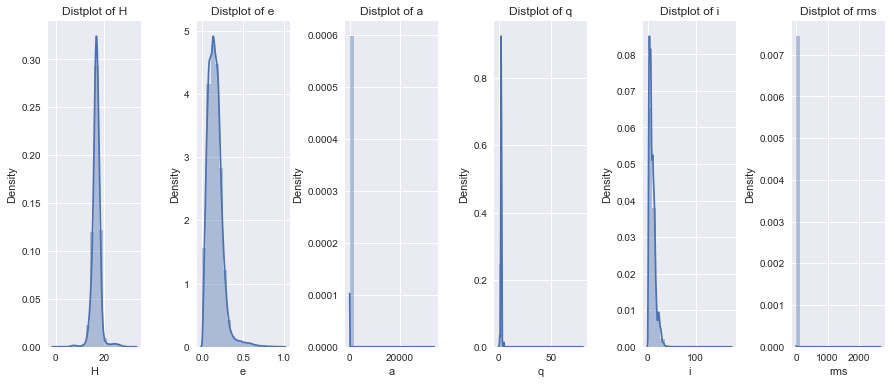

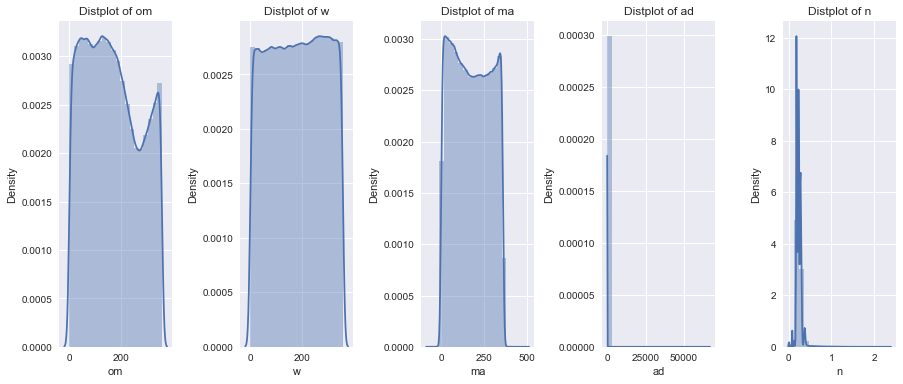

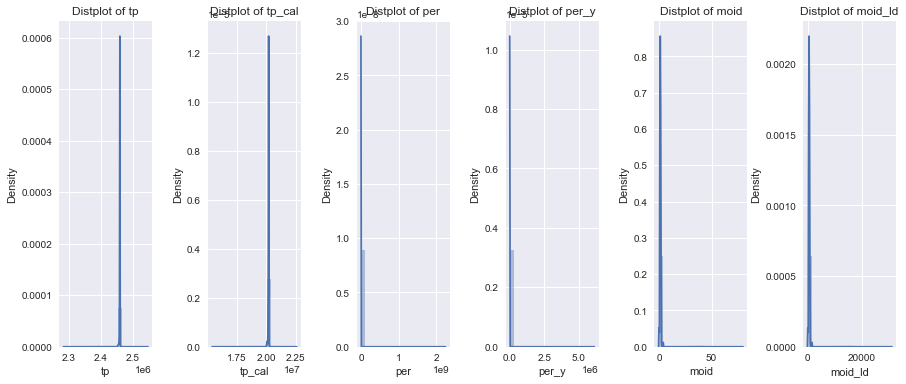

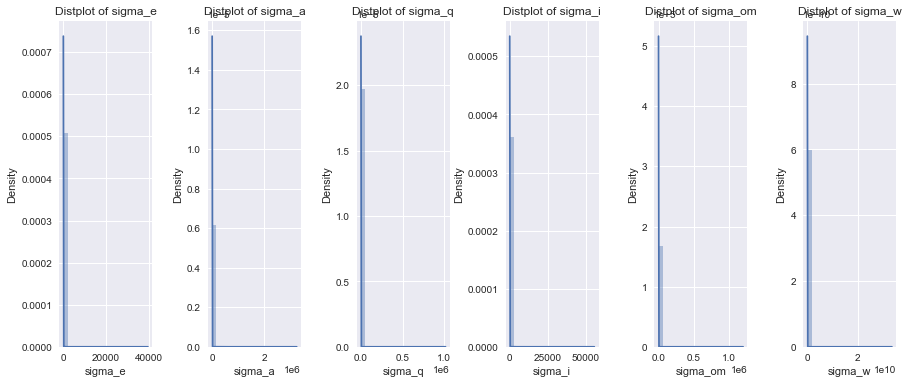

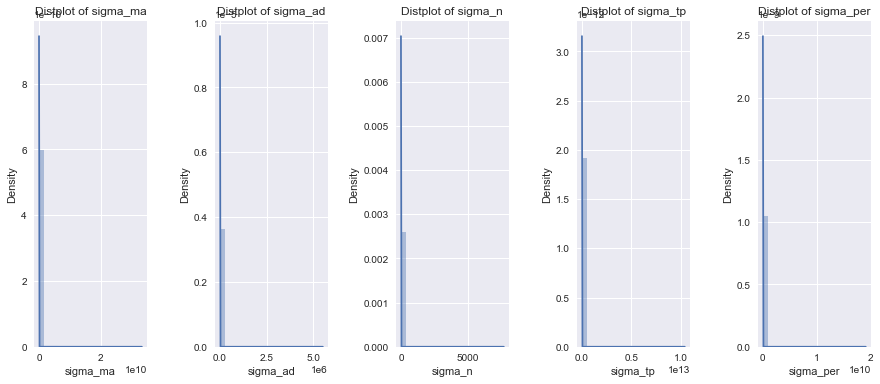

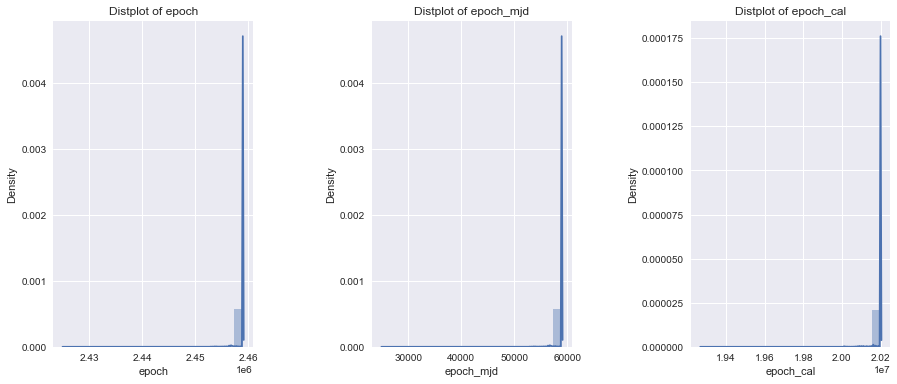

In [24]:
# Features
features_list_1 = ['H','e','a','q','i','rms']
features_list_2 = ['om','w','ma','ad','n']
features_list_3 = ['tp','tp_cal','per','per_y','moid','moid_ld']
features_list_4 = ['sigma_e','sigma_a','sigma_q','sigma_i','sigma_om','sigma_w']
features_list_5 = ['sigma_ma','sigma_ad','sigma_n','sigma_tp','sigma_per']
features_list_6 = ['epoch','epoch_mjd','epoch_cal']

# Feature Distribution Plots
the_plot_thickens(asteroid_data, features_list_1, len(features_list_1)),
the_plot_thickens(asteroid_data, features_list_2, len(features_list_2)),
the_plot_thickens(asteroid_data, features_list_3, len(features_list_3)),
the_plot_thickens(asteroid_data, features_list_4, len(features_list_4)),
the_plot_thickens(asteroid_data, features_list_5, len(features_list_5)),
the_plot_thickens(asteroid_data, features_list_6, len(features_list_6))

With the help of the distribution plots we can see that there indeed are some outliers for a high number of the features. Some plots are basically unreadable and I would say the cause for this is that the outlier values are much different than the mean values of the features. 

We can also assume that some of the features are very closely related due to their identical distribution (and in some cases name). Examples would be a and ad, all sigma variants and all per variants.


Let's attempt to deal wit hthe outlier values.

### 1.3.3 Outlier Removal
I will be using standard deviation to set thresholds for each feature. Panda's percentile is also an option which will give me more control if I want to set threshold for each feature manually to a certain percetage. 

In [25]:
asteroid_data.shape

(932335, 34)

In [26]:
# Creating a disctionary with outlier thresholds for each feature of interest

features_with_outliers = ['a', 'ad', 'rms', 'sigma_e', 'per', 'per_y', 'sigma_n', 'sigma_per', 'epoch', 'tp', 'n', 'moid', 'q', ] 

outlier_thresholds = {'Feature Name':[],'Max Threshold':[],'Min Threshold':[]};
for x in features_with_outliers:
    
    #min_threshold, max_threshold = asteroid_data[x].quantile([0.000003, 0.9995]) # No positive DHA removed
    #min_threshold, max_threshold = asteroid_data[x].quantile([0.003, 0.97]) # Starting out with high thresholds
    max_threshold = asteroid_data[x].mean() + 1*asteroid_data[x].std()
    min_threshold = asteroid_data[x].mean() - 0.6*asteroid_data[x].std()
    
    outlier_thresholds['Feature Name'].append(x)
    outlier_thresholds['Max Threshold'].append(max_threshold)
    outlier_thresholds['Min Threshold'].append(min_threshold)   
outlier_thresholds['Max Threshold'].reverse    
#print(outlier_thresholds)

<function list.reverse()>

While removing the outliers i also want to make sure that I am not sacraficing any positive PHA values as they are very few already.

In [27]:
# Filtering out observations per feature based on the above defined thresholds

asteroid_data_outliers_removed = asteroid_data
i = 0
for x in outlier_thresholds['Feature Name']:
    
    feature_name = outlier_thresholds['Feature Name'][i]
    max_threshold = outlier_thresholds['Max Threshold'][i]
    min_threshold = outlier_thresholds['Min Threshold'][i]
    
    print(feature_name)
    #print(max_threshold)
    #print(min_threshold)
    
    asteroid_data_outliers_removed = asteroid_data_outliers_removed[
        (asteroid_data_outliers_removed[feature_name] < max_threshold) & 
        (asteroid_data_outliers_removed[feature_name] > min_threshold)
             ]
    i += 1
    
    #print(df2.shape)
    print(asteroid_data_outliers_removed.groupby("pha").size())
    print("-----------")
    
print(asteroid_data_outliers_removed.shape)

a
pha
N    927193
Y      2066
dtype: int64
-----------
ad
pha
N    927193
Y      2066
dtype: int64
-----------
rms
pha
N    927177
Y      2066
dtype: int64
-----------
sigma_e
pha
N    927132
Y      2066
dtype: int64
-----------
per
pha
N    927132
Y      2066
dtype: int64
-----------
per_y
pha
N    927132
Y      2066
dtype: int64
-----------
sigma_n
pha
N    927127
Y      2066
dtype: int64
-----------
sigma_per
pha
N    927127
Y      2066
dtype: int64
-----------
epoch
pha
N    895440
Y      1926
dtype: int64
-----------
tp
pha
N    892348
Y      1925
dtype: int64
-----------
n
pha
N    643115
Y       546
dtype: int64
-----------
moid
pha
N    641213
dtype: int64
-----------
q
pha
N    640672
dtype: int64
-----------
(640672, 34)


We can see that epoch, tp, n, moid and q are good indicators for PHA as the positive values start dropping when attempting to remove outliers.

Moid and q in particular have a very strong relationship with DHA since all of the positive values dissappear when attempting to remove values lower than 0.6 * std. I have tested both moid and q separately and they have nearly the same effect on the PHA values.

A deeper understanding of the domain and all of the avaialble features would be of great help when determining outlier thresholds. For now I will just try and fine tune the outlier thresholds for some of the features in such a way that no positive PHA entries will be lost. Hopefully that will make the distribution plots a bit more readable.

I want to keep an eye on the amount of total entries removed and make sure that no positive PHA values are sacraficed in the process as they are already few few. To achieve that I will simply print the grouped PHA values before and after each feature get treated.

In [28]:
# Copying the dataframe to keep the original for future reference
asteroid_data_outliers_removed = asteroid_data #resetting the dataframe 

# a

print(asteroid_data_outliers_removed.groupby("pha").size())

min_threshold_a, max_threshold_a = asteroid_data_outliers_removed.a.quantile([0.000001, 0.995])
max_threshold_a = asteroid_data_outliers_removed.a.mean() + 0.5*asteroid_data_outliers_removed.a.std()
min_threshold_a = asteroid_data_outliers_removed.a.mean() - 1*asteroid_data_outliers_removed.a.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.a < max_threshold_a) & 
                                                                (asteroid_data_outliers_removed.a > min_threshold_a)]
print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    930269
Y      2066
dtype: int64
pha
N    926659
Y      2066
dtype: int64


Both a and ad seem to have the exact same behaviour so I will only treat one.

In [29]:
# sigma_e

print(asteroid_data_outliers_removed.groupby("pha").size())

min_threshold_sigma_e, max_threshold_sigma_e = asteroid_data_outliers_removed.sigma_e.quantile([0.000001, 0.995])
max_threshold_sigma_e = asteroid_data_outliers_removed.sigma_e.mean() + 0.2*asteroid_data_outliers_removed.sigma_e.std()
min_threshold_sigma_e = asteroid_data_outliers_removed.sigma_e.mean() - 0.003*asteroid_data_outliers_removed.sigma_e.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.sigma_e < max_threshold_sigma_e) & 
                                                                (asteroid_data_outliers_removed.sigma_e > min_threshold_sigma_e)]
print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    926659
Y      2066
dtype: int64
pha
N    926617
Y      2066
dtype: int64


Most PHA positives are in the extreme low end of sigma. I am assunming that just like ad, all sigma variants share the same outlier profile so will only treat one.

In [30]:
# rms

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_rms = asteroid_data_outliers_removed.rms.mean() + 0.4*asteroid_data_outliers_removed.rms.std()
min_threshold_rms = asteroid_data_outliers_removed.rms.mean() - 1*asteroid_data_outliers_removed.rms.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.rms < max_threshold_rms) & 
                                                                (asteroid_data_outliers_removed.rms > min_threshold_rms)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    926617
Y      2066
dtype: int64
pha
N    926544
Y      2066
dtype: int64


In [31]:
# per

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_per = asteroid_data_outliers_removed.per.mean() + 49*asteroid_data_outliers_removed.per.std()
min_threshold_per = asteroid_data_outliers_removed.per.mean() - 2.8*asteroid_data_outliers_removed.per.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.per < max_threshold_per) & 
                                                                (asteroid_data_outliers_removed.per > min_threshold_per)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    926544
Y      2066
dtype: int64
pha
N    926483
Y      2066
dtype: int64


The values in the upper range of per are a good indicator for positive PHA as they quickly start dissappearing if I decrease the upper threshold.

In [32]:
# moid

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_moid = asteroid_data_outliers_removed.moid.mean() + 3*asteroid_data_outliers_removed.moid.std()
min_threshold_moid = asteroid_data_outliers_removed.moid.mean() - 2.7*asteroid_data_outliers_removed.moid.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.moid < max_threshold_moid) & 
                                                                (asteroid_data_outliers_removed.moid > min_threshold_moid)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    926483
Y      2066
dtype: int64
pha
N    918104
Y      2066
dtype: int64


Contains all positive PHA values in the low end.

In [33]:
# epoch

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_epoch = asteroid_data_outliers_removed.epoch.mean() + 0.2*asteroid_data_outliers_removed.epoch.std()
min_threshold_epoch = asteroid_data_outliers_removed.epoch.mean() - 24*asteroid_data_outliers_removed.epoch.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.epoch < max_threshold_epoch) & 
                                                                (asteroid_data_outliers_removed.epoch > min_threshold_epoch)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    918104
Y      2066
dtype: int64
pha
N    918093
Y      2066
dtype: int64


Epoch is extremely sensitive in its lower threshold with most PHA values being lost with a outlier threshold lower than 24 * std.

In [34]:
# H

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_H = asteroid_data_outliers_removed.H.mean() + 3.3*asteroid_data_outliers_removed.H.std()
min_threshold_H = asteroid_data_outliers_removed.H.mean() - 3*asteroid_data_outliers_removed.H.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.H < max_threshold_H) & 
                                                                (asteroid_data_outliers_removed.H > min_threshold_H)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    918093
Y      2066
dtype: int64
pha
N    902710
Y      2066
dtype: int64


In [35]:
# e

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_e = asteroid_data_outliers_removed.e.mean() + 10*asteroid_data_outliers_removed.e.std()
min_threshold_e = asteroid_data_outliers_removed.e.mean() - 1.7*asteroid_data_outliers_removed.e.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.e < max_threshold_e) & 
                                                                (asteroid_data_outliers_removed.e > min_threshold_e)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    902710
Y      2066
dtype: int64
pha
N    900949
Y      2066
dtype: int64


Positive PHA velues reside in the extreme upper end of e

In [36]:
# i

print(asteroid_data_outliers_removed.groupby("pha").size())

max_threshold_i = asteroid_data_outliers_removed.i.mean() + 11*asteroid_data_outliers_removed.i.std()
min_threshold_i = asteroid_data_outliers_removed.i.mean() - 1.7*asteroid_data_outliers_removed.i.std()

asteroid_data_outliers_removed = asteroid_data_outliers_removed[(asteroid_data_outliers_removed.i < max_threshold_i) & 
                                                                (asteroid_data_outliers_removed.i > min_threshold_i)]

print(asteroid_data_outliers_removed.groupby("pha").size())

pha
N    900949
Y      2066
dtype: int64
pha
N    900921
Y      2066
dtype: int64


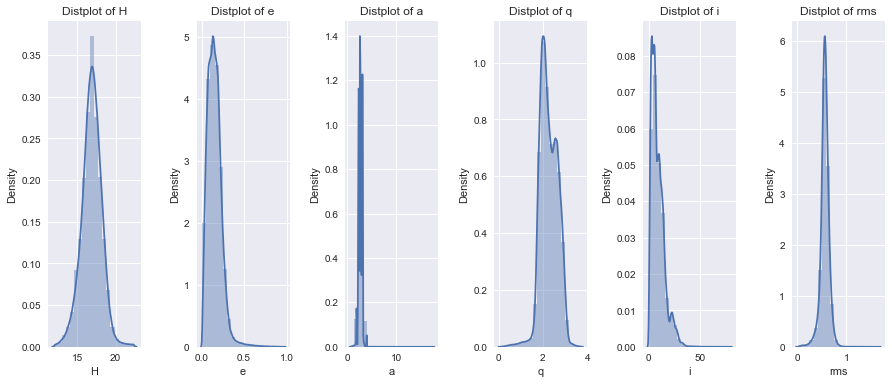

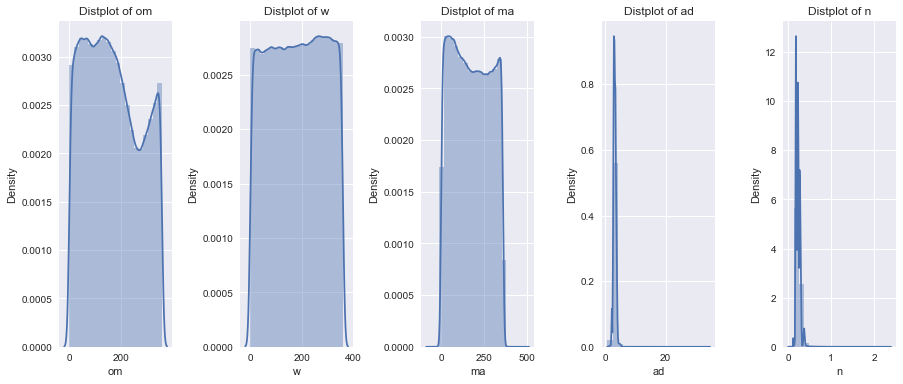

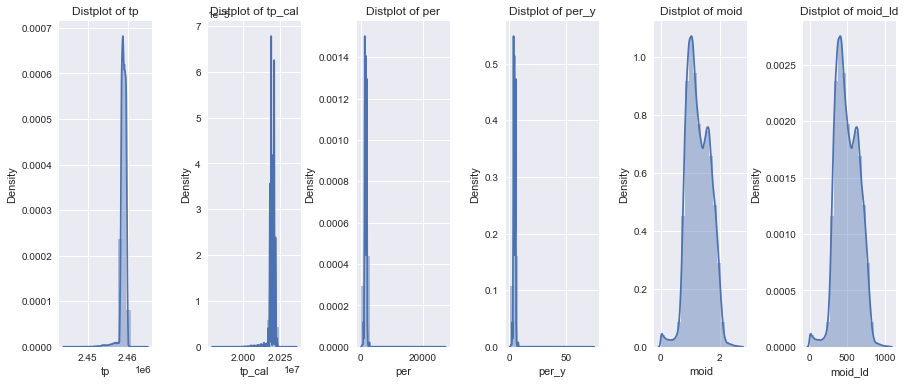

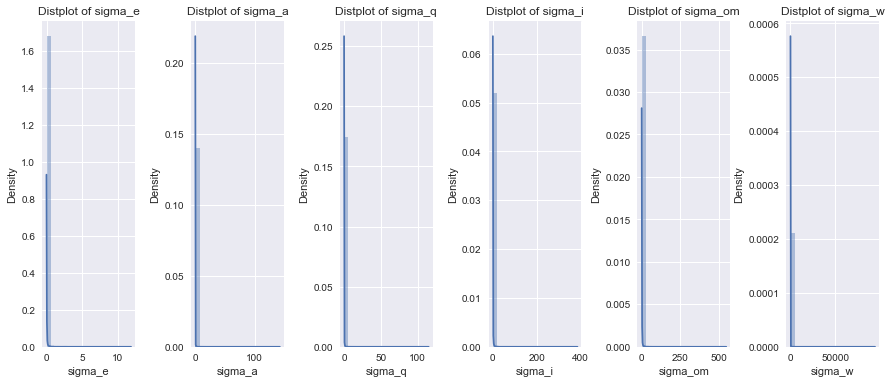

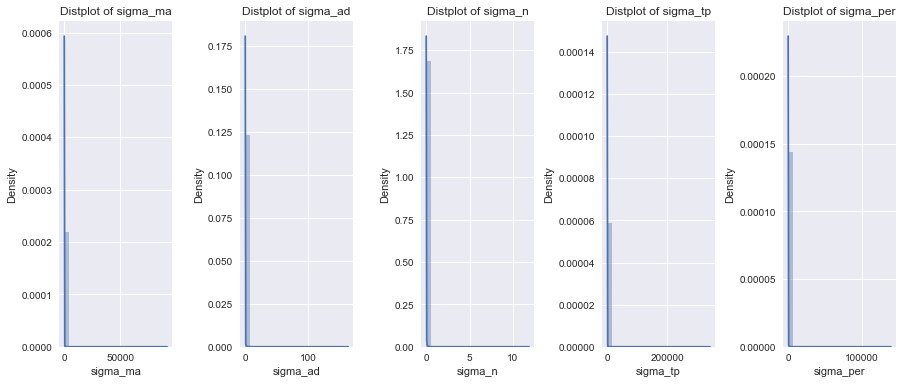

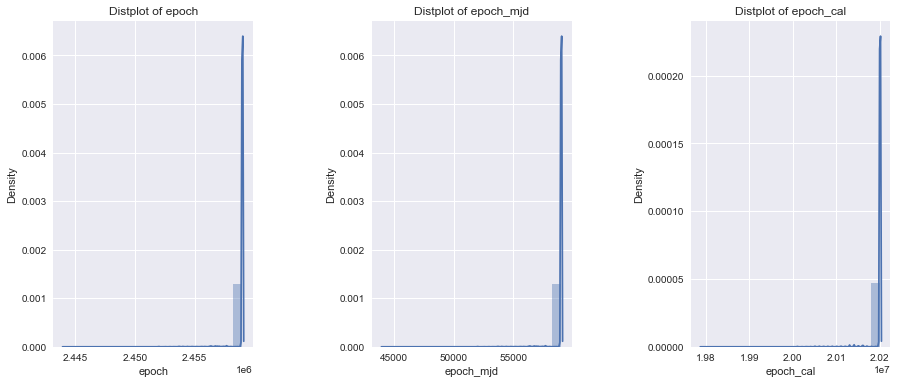

In [37]:
# Outliers removed distribution plots
the_plot_thickens(asteroid_data_outliers_removed, features_list_1, len(features_list_1))
the_plot_thickens(asteroid_data_outliers_removed, features_list_2, len(features_list_2))
the_plot_thickens(asteroid_data_outliers_removed, features_list_3, len(features_list_3))
the_plot_thickens(asteroid_data_outliers_removed, features_list_4, len(features_list_4))
the_plot_thickens(asteroid_data_outliers_removed, features_list_5, len(features_list_5))
the_plot_thickens(asteroid_data_outliers_removed, features_list_6, len(features_list_6))

I have removed all of the outliers that I can without sacraficing any of the PHA positive values. Any adjustments to the upper or lower threshodls (increase and decrease respectively) for any of the features results in a drastic drop or in some cases the complete removal of all of the positive PHA values. The nature of the data is such that the outlier removal approach cannot be overly aggressive as it seems that the positive PHA values themselves reside in the extreme end of the feature distributions and are in a way outliers.

Below I will illustrate the effect I am referring to and will use moid as the example. I will use a unaltered copy of the dataframe for the demonstration:

In [38]:
# Setting up a unaltered dataframe for demonstration purposes
asteroid_data_outliers_removed_demonstration = asteroid_data  

# moid
print(asteroid_data_outliers_removed_demonstration.groupby("pha").size())

max_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() + 0.5*asteroid_data_outliers_removed_demonstration.moid.std()
#min_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() - 0.6*asteroid_data_outliers_removed_demonstration.moid.std()
min_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() - 0.7*asteroid_data_outliers_removed_demonstration.moid.std()
asteroid_data_outliers_removed_demonstration = asteroid_data_outliers_removed_demonstration[(asteroid_data_outliers_removed_demonstration.moid < max_threshold_moid) & 
                                                                (asteroid_data_outliers_removed_demonstration.moid > min_threshold_moid)]

print(asteroid_data_outliers_removed_demonstration.groupby("pha").size())

pha
N    930269
Y      2066
dtype: int64
pha
N    917802
Y      2066
dtype: int64


In [39]:
# Resetting the demonstration dataframe to illustrate the difference in thresholds
asteroid_data_outliers_removed_demonstration = asteroid_data  

# moid
print(asteroid_data_outliers_removed_demonstration.groupby("pha").size())

max_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() + 0.5*asteroid_data_outliers_removed_demonstration.moid.std()
min_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() - 0.6*asteroid_data_outliers_removed_demonstration.moid.std()
#min_threshold_moid = asteroid_data_outliers_removed_demonstration.moid.mean() - 0.7*asteroid_data_outliers_removed_demonstration.moid.std()
asteroid_data_outliers_removed_demonstration = asteroid_data_outliers_removed_demonstration[(asteroid_data_outliers_removed_demonstration.moid < max_threshold_moid) & 
                                                                (asteroid_data_outliers_removed_demonstration.moid > min_threshold_moid)]

print(asteroid_data_outliers_removed_demonstration.groupby("pha").size())

pha
N    930269
Y      2066
dtype: int64
pha
N    903760
dtype: int64


First it is important to note that the threshold values used in the demonstration are differnet than the ones used in the actual outlier removal process above. That is because this dataframe has not been altered whereas the one used in the outlier removal has been altered by all the features which came before H.

In the above demo we can see that if the minimum threshold for H is set to 0.6 times the STD we lose all positive PHA observations but by only adjusting that value to 0.7 times STD we get them all back. If we also consider that the total number of observation removed are <b>~2%</b> than it does seem that the positive PHA values are outliers themselves.


An interresting point to note is that since so much of the interesting entries lie at the extreme end of the data then this dataset should be suitable for anomaly detection.

------------------------  Outliers removed plots  -------------------------


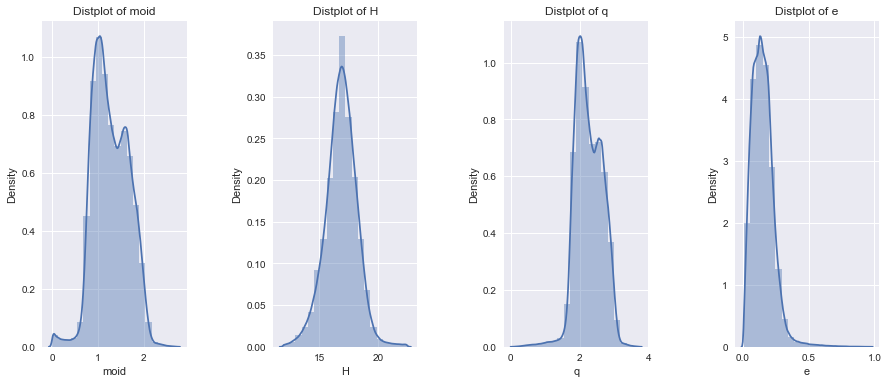

------------------------  Demo Plots  ------------------------


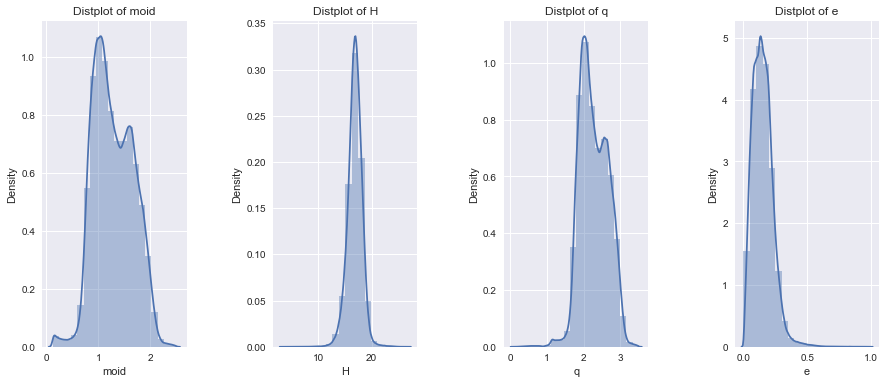

In [40]:
# Comparison of dsitribution plots for main features

features_list_demo = ['moid','H', 'q', 'e'] # ,'a','i','rms', 'sigma_e'

print("------------------------  Outliers removed plots  -------------------------"),
the_plot_thickens(asteroid_data_outliers_removed, features_list_demo, len(features_list_demo)),
print("------------------------  Demo Plots  ------------------------"),
the_plot_thickens(asteroid_data_outliers_removed_demonstration, features_list_demo, len(features_list_demo))

The feature distribution plots have remained largly unchanged. Due to the low ratio of positive PHA values in the dataset they get lost amongst the rest of the observations.

Let's save the outliers removed data as our default and move on to the next step.

In [41]:
# Adding in the outliers removed verion of the dataframe

asteroid_data = asteroid_data_outliers_removed
asteroid_data.shape,
print(asteroid_data.groupby("pha").size())

pha
N    900921
Y      2066
dtype: int64


In [42]:
# Copying the cleaned data before scaling just in case

asteroid_data_clean = asteroid_data

### Separating the Target variable and transforming it manually



In [43]:
# Labels - Targets split

pha = asteroid_data.pha
asteroid_attributes = asteroid_data.drop("pha", axis = 1)

In [44]:
#pha.loc[pha == "Y"] = 1
#pha.loc[pha == "N"] = 0

pha.replace(to_replace='Y', value=1, inplace=True)
pha.replace(to_replace='N', value=0, inplace=True)

pha=pha.astype('int64')

## 1.4 Scaling
- Categorical variable will be encoded with OneHotEncoder;
- For numerical ones I will use StandartScaler since a large amount (if not all) of the data important to me lies within the extreme ends of the feature distributions. Keeping the natural distribution of the features unchanged will be very important and MinMaxScaler can have a "squishing" effect on the distribution;

In [45]:
# Establishing a pipeline

numeric_cols = asteroid_attributes.select_dtypes(include = ['int64', 'float64']).columns
categorical_cols = asteroid_attributes.select_dtypes(include = ['object']).columns

num_pipeline = Pipeline(steps = [
#     ('MinMaxScaler', MinMaxScaler())
    ('StandardScaler', StandardScaler())
])

cat_pipeline = Pipeline(steps = [
    ('ohe', OneHotEncoder(drop = "first"))
])

preprocessor = ColumnTransformer([
                    ("num", num_pipeline, numeric_cols),
                    ("cat", cat_pipeline, categorical_cols)
                ])
print(numeric_cols)
print(categorical_cols)
asteroid_attributes_scaled = preprocessor.fit_transform(asteroid_attributes)

Index(['H', 'epoch', 'epoch_mjd', 'epoch_cal', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'rms'],
      dtype='object')
Index(['neo', 'class'], dtype='object')


In [46]:
asteroid_attributes_scaled.shape

(902987, 42)

An increase in column count is not ideal considering that the dataset is quite large already. This increase is coming due to the number of categories in the class variable. Removing class could be an option if it proves to not be important in the classification. NEO should not be a contributing factor as it only contains two possible values and the <b>drop="first"</b> argument for OneHotEncoder should have left only one after the transformation.

## 1.5 Train/Test split

Since I have a lot of data at my disposal I will not do a cross validation but instead use only a test set. With this number of observations a single test set should be enough and also a CV on this amount of data may prove a bit too slow when tuning hyper parameters for the various models.

As I have a severe class imbalance, stratification is a very important step to make sure that the class distribution is kept the same across both the training and test sets.


In [47]:
# Train/Test Split

asteroid_attributes_train, asteroid_attributes_test, pha_train, pha_test = train_test_split(
    asteroid_attributes_scaled,
    pha,
    stratify=pha,
    random_state=43,
    test_size=100000 
)

In [48]:
# Validation split

# asteroid_attributes_train, asteroid_attributes_val, pha_train, pha_val = train_test_split(
#     asteroid_attributes_train,
#     pha_train,
#     stratify=pha_train,
#     random_state=43,
#     test_size=100000  
# )

In [49]:
# Checking attributes shape

asteroid_attributes_train.shape, pha_train.value_counts()

((802987, 42),
 0    801150
 1      1837
 Name: pha, dtype: int64)

In [50]:
# Checking targets shape

asteroid_attributes_test.shape, pha_test.value_counts()

((100000, 42),
 0    99771
 1      229
 Name: pha, dtype: int64)

Class ratios have indeed been retained.

# 2. Testing, optimizing and comparing classification algorithms

A simple logistic regression will be my starting point as it is simple to run and rather quick. It will let us judge the potential of the data and also let us know what we can expect in terms of training time.

## 2.1 Logistic Regression

Let's start off with just the default parameters to establish a baseline score:

- C = 1
- max_iter = 100
- fit_intercept = True


Later on we can tune these parameters to improve the model's accuracy.

In [51]:
log_r = LogisticRegression(random_state=43)
log_r.fit(asteroid_attributes_train, pha_train)

C:\Users\ksbon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=43)

In [52]:
# Train set accuracy

log_r.score(asteroid_attributes_train, pha_train)

0.9992079572894704

In [53]:
# Test set accuracy

log_r.score(asteroid_attributes_test, pha_test)

0.99917

In [54]:
log_r.intercept_ # value of y if x is 0

array([-44.55031972])

Surprisingly the accuracy scores are quite high however the accuracy score doesn't tell us much about the label specific performance. The harmonic score of precision and recall (f1) for each class would be a much more useful metric which we can get from a calssification report. 

Comparing the train set and test set scores can give us some insight into the model's behaviour as well. If the results are similar but the score is low then we are dealing with high variance and the model is likely missing something (perhaps a relationship in the data) or just doesn't have the capacity for the given dataset. If the scores differ too much then the model is biased towards the training set and we need to increase it's variance.

When dealing with minority classes precision becomes the most important metric as in this case even a single missclassified observation will significantly impact our end result.


### Creating metrics functions

Let's define some functions to call upon whenever these metrics are required.

A basic calssification report will give us an overview of the model's precision and recall. We can also use two - one for the training dat and one for the testing data. That way we can compare and make more accurate assesments on the model's bias and variance.

In [55]:
# Train Test classification reports function

def train_test_classification_report(train_target, train_predictions, test_target, test_predictions):
    print(),
    print("--------------------  Train set scores  --------------------"),
    print(classification_report(train_target, train_predictions)),
    print(),
    print("--------------------  Test set scores  --------------------"),
    print(classification_report(test_target, test_predictions))

Additionally a confusion matrix will be able to tell us exactly how the model divided up the labels into (in this case) the four possible categories - True Positive, False Positive, True Negative and False Negative. What we are striving for is to have no false results at all but what we are mainly interested in are the positives as they are our target and are also the minority class. 

In [56]:
# Confusion matrix plot

def plot_confusion_matrix(confusion_matrix):

    cf_matrix = confusion_matrix

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.subplots(figsize=(10, 6))
    plt.xticks(fontsize= 20)
    plt.yticks(fontsize = 20)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', linewidths=6, annot_kws={"size": 15},)

    #plt.show

A <b>Precision-Recall curve</b> curve is a valuable metric as well which can be used to visualize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. We want our curve to be as high as possible and the larger the area under the curve is the better the algorithm is performing. This curve is the better option over a ROC curse in our case due to the label imbalance in the dataset. It focuses more on the precision score than on the f1 score like the ROC curve which is used for more balanced classes.


In [57]:
# Precision-Recall Curve function

def plot_precision_recall_curve(model_decision_function, labels_test):

    #Labels score
    labels_score = model_decision_function

    # Precision and recall
    precision, recall, _ = precision_recall_curve(labels_test, labels_score)

    # Average precision
    average_precision = average_precision_score(labels_test, labels_score)

    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    #plt.show

#### Logistic regression metrics

In [58]:
# Logistic regression classification reports

train_test_classification_report(
    pha_train, 
    log_r.predict(asteroid_attributes_train), 
    pha_test, 
    log_r.predict(asteroid_attributes_test)
    ) 


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       0.83      0.82      0.83      1837

    accuracy                           1.00    802987
   macro avg       0.91      0.91      0.91    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.83      0.80      0.82       229

    accuracy                           1.00    100000
   macro avg       0.91      0.90      0.91    100000
weighted avg       1.00      1.00      1.00    100000



Initial results are prommising. In the classification reports we can see similar results for both the test and the train sets indicating that the model's variance is good and there is not much overfitting. Overall the model is retrieving a lot of information from the dataset.

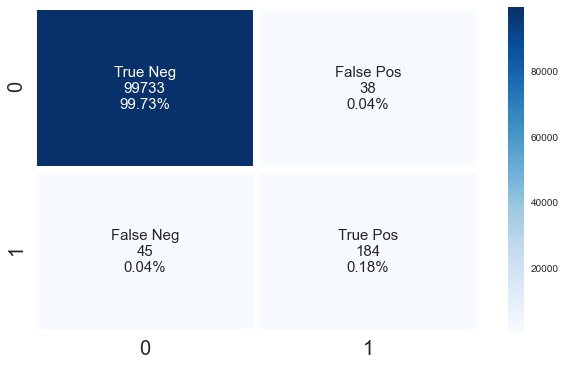

In [59]:
# Logistic regression confusion matrix

plot_confusion_matrix(confusion_matrix(pha_test, log_r.predict(asteroid_attributes_test)))

On the confusion matrix we can see that 184 positive PHA observations out of the 229 have been correctly predicted and the remaining 45 were falsy calssified as negative. There are also 38 false positives which indicates that the model is having issues with clearly separating the true positive and the true negative values.

There are a couple of options we can try to adress these issues. First let's try to optimize the model's performance by tweaking its parameters in a grid search.

### Logistic regression Grid Search
From the baseline model which was run we received a convergence warning meaning that the model's default solver was unable to minimize its loss function which can be addressed by increasing the <b>max_iter</b> parameter value.

I would also like to play around with the regularization parameter <b>C</b>. It has an inverse reaction to the feature weights so I will try a few different values from all across the spectrum.

In [60]:
# log_r_params = {
#     #"C": [0.0001, 0.01, 0.1, 1, 10, 100, 300, 700, 1000, 10000],  # 50
#     #"max_iter": [50, 100, 200, 300, 500, 700, 1000],  # 700
#     #"fit_intercept": [True, False]  # True
    
#     "C": [0.1, 1, 10, 50, 100, 300],  # 50
#     "max_iter": [100, 250, 500, 700, 1000],  # 700
#     "fit_intercept": [True, False],  # True
# }

# grid_search_log_r = GridSearchCV(estimator = LogisticRegression(random_state=43), 
#                                  param_grid=log_r_params, 
#                                  scoring='f1',
#                                  n_jobs=n_jobs_custom
#                                 )
# grid_search_log_r.fit(asteroid_attributes_train, pha_train)

#grid_search_log_r.best_estimator_

#### Saving grid_search_log_r
Commenting out the grid search above to save on time with consecutive runs of the notebook

In [61]:
#joblib.dump(grid_search_log_r, "grid_search_log_r")
grid_search_log_r = joblib.load("grid_search_log_r")

In [62]:
# Best estimators for reference 

grid_search_log_r.best_estimator_

LogisticRegression(C=50, max_iter=700, random_state=43)

#### Optimized Logistic regression metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       0.86      0.87      0.86      1837

    accuracy                           1.00    802987
   macro avg       0.93      0.93      0.93    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.86      0.89      0.88       229

    accuracy                           1.00    100000
   macro avg       0.93      0.95      0.94    100000
weighted avg       1.00      1.00      1.00    100000



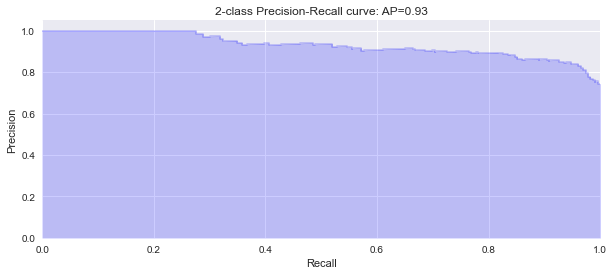

In [63]:
train_test_classification_report(pha_train, 
                                 grid_search_log_r.best_estimator_.predict(asteroid_attributes_train),
                                 pha_test, 
                                 grid_search_log_r.best_estimator_.predict(asteroid_attributes_test)
                                )
plot_precision_recall_curve(grid_search_log_r.best_estimator_.decision_function(asteroid_attributes_test), pha_test)

Scores have improved all around. Both precision and recall have increased though not by all that much.

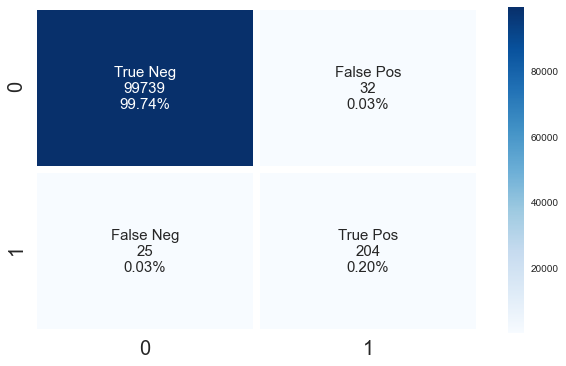

In [64]:
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_log_r.best_estimator_.predict(asteroid_attributes_test)))

The confusion matrix is also showing a decrease in falsly calssified observations with the false negatives dropping almost by half which is why out of the two metric recall has improved the most. False positives have not improved much so the class separation issue still persists.

In [65]:
# Logistic regression cv results

grid_search_log_r.cv_results_

{'mean_fit_time': array([ 27.68918152,  69.55505457, 113.43320203, 113.56255002,
        115.06720533,  27.81717477,  68.32488952,  68.82222252,
         68.84160981,  69.27618542,  29.51043682,  72.04039679,
        144.33610287, 199.6341073 , 245.66988935,  27.89501662,
         67.90060668, 130.14628773, 131.27261677, 130.85433908,
         28.03049507,  68.83904443, 137.98302498, 191.73787818,
        272.47267661,  26.89713116,  66.80932827, 133.8738759 ,
        188.72964649, 279.71438885,  27.9574492 ,  71.59868588,
        143.78401766, 201.81154509, 284.84815145,  28.98322773,
         70.01502037, 138.00119963, 197.0358839 , 280.5497262 ,
         29.22817531,  69.60971279, 140.2539732 , 193.73208122,
        278.158776  ,  27.59300613,  68.79319062, 140.52746768,
        193.69779563, 274.0346797 ,  28.37721834,  70.65347013,
        136.27202215, 190.53137355, 273.43735342,  26.88191419,
         67.20961447, 135.50336342, 158.34737525, 168.35165854]),
 'std_fit_time': arra

The feature weights across the grid search do not differ much which means that we are close to the optimal performance of the logistic regression on this dataset in its current state. To proceed I would like to improve the data by balancing out the calsses. Hopefully that should give the model enough examples so that labels become more easily separable. 

## 2.2 SMOTE

As I have a 1000/1 imbalance in my classes I will use oversampling to artificially create additional positive PHA entries. From <b>imbalanced-learn</b> I will import <b>SMOTE</b> (Synthetic Minority Oversampling Technique) which utilizes KNN by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Parameters that will be input are:

- sampling_strategy="minority" seeing as we are dealing with a minority class;
- k_neighbors - I played around with this value and found that 1300 gives me the best results. I believe the reason for this is that a high number of neighbors would increase the data variance and make it more representative of the original distribution of the minority class. 

In [66]:
# Setting up SMOTE and sacing the bootstrapped data in new variables for testing

smote = SMOTE(sampling_strategy="minority", k_neighbors= 1300, random_state = 43)
asteroid_attributes_train_smote, pha_train_smote = smote.fit_resample(asteroid_attributes_train, pha_train)

In [67]:
# Base train values distributions

pha_train.value_counts()

0    801150
1      1837
Name: pha, dtype: int64

In [68]:
# Bootstrapped observations distribution

pha_train_smote.value_counts()

0    801150
1    801150
Name: pha, dtype: int64

The value counts showcase that the original data has been modified to include an equal amount of positive and negative observations. A significant downside is that the size of the dataset has nearly doubled which we slow down my already long training times.

## 2.3 Logistic Regression with SMOTE

Let's test the bootstrapped data on a logistic regression with the best performing parameters. Due to the increased amount of data I will also increase the max_iter parameter to make sure the algoritm has enough iterations minimize the function. 

Since the size of the dataset has nearly doubled I also tried fitting a stochastic average gradient descent solver as it should be quicker to process and in particular <b>saga</b> which also allows for l1 regularization. Unfortunately it seems that with the current scaling of the data the saga solver is actually slower tha the default and I was unable to complete the model training and I am forced to proceed with the default solver which I know will work in a reasonable timeframe.

In [69]:
# log_r_smote = LogisticRegression(random_state=43, 
#                                  C=50, 
#                                  max_iter=4000, 
#                                  fit_intercept=True, 
#                                  #solver="saga", 
#                                  #penalty = 'elasticnet',
#                                  #l1_ratio=0.5
#                                  )
# log_r_smote.fit(asteroid_attributes_train_smote, pha_train_smote)

#### Saving log_r_smote
Running this model took quite a long time considering the dataset size and the 4000 iterations needed so I am saving it to make future use of the notebook more convenient.

In [70]:
# Saving and loading the model

#joblib.dump(log_r_smote, "log_r_smote")
log_r_smote = joblib.load("log_r_smote")

It appears tha SMOTE has helped out the recall score but at the expense of accuracy. The train scores on the other hand are perfect which indicates a high level of bias.

#### Logistic Regression SMOTE metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.69      1.00      0.82       229

    accuracy                           1.00    100000
   macro avg       0.85      1.00      0.91    100000
weighted avg       1.00      1.00      1.00    100000



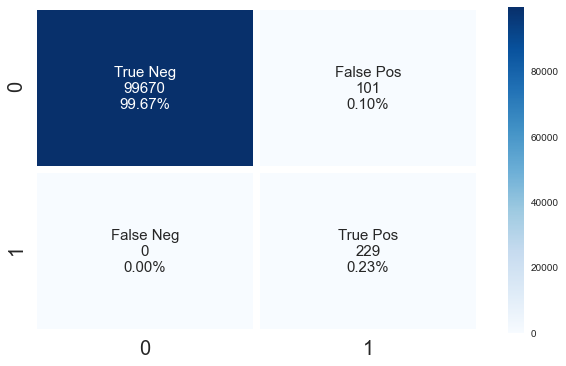

In [71]:
train_test_classification_report(pha_train_smote,
                                 log_r_smote.predict(asteroid_attributes_train_smote),
                                 pha_test, 
                                 log_r_smote.predict(asteroid_attributes_test)
                                )

plot_confusion_matrix(confusion_matrix(pha_test, log_r_smote.predict(asteroid_attributes_test)))

We can see that the model is successfully identifiyng all of the 229 true positive PHA values of the test set but is also seeing 101 negative observations as positive. The false negatives have successfully been eliminated but at the expense of an increase in false positives. The SMOTE data has improved the recall but at the expense of precision. 

### 2.3.1 Logostic Regression with SMOTE parameter optimization
Let's try and optimize the hyperparameters of the logistic SMOTE regression to improve the scores:

- Like the non bootstrapped logistic regression run, I do need to increase the <b>max_iter</b> value but considering that we have a lot more data to work with the increase will need to be significant. 


- I do want to also play around with the <b>C</b> parameter as I expect that an increase in regularization will lead to a reduction in bias;


- Lastly I will swap the grid search's scoring method to <b>precision</b> as that is the weakest aspect of the model currently.

In [72]:
# Grid search

# log_r_smote_params = {
#     #"C": [0.0001, 0.01, 0.1, 1, 10, 100, 300, 700, 1000, 10000],  # 10
#     #"max_iter": [50, 100, 200, 300, 500, 700, 1000],  # 700
#     #"fit_intercept": [True, False]  # False
    
#     "C": [50, 100, 200],  # 50
#     "max_iter": [4000, 5000],  # 700
#     #"fit_intercept": [True, False],  # True
# }

# grid_search_log_r_smote = GridSearchCV(estimator = LogisticRegression(random_state=43), 
#                                        param_grid=log_r_smote_params, 
#                                        scoring='precision',
#                                        n_jobs=n_jobs_custom
#                                       )
# grid_search_log_r_smote.fit(asteroid_attributes_train_smote, pha_train_smote)

# grid_search_log_r_smote.best_estimator_

I was never able to successfully run the grid_search for the bootstrapped log_r since it took very long to complete and I had to give up on it. I did run the base version of the bootstrapped logistic regression with a max_iter=4000 and the algorithm was able to converge but the results were unchanged meaning that the model's loss function on this data is nearly horizontal and the results can't be improved much. That is also supported by the fact that the scores between the optimized and not optimized bootstrapped logistic regressions is unchanged.

#### Saving grid_search_log_r_smote
Commenting out the code above to save in time with consecutive runs

In [73]:
# Saving and loading the model

#joblib.dump(grid_search_log_r_smote, "grid_search_log_r_smote")
grid_search_log_r_smote = joblib.load("grid_search_log_r_smote")

In [74]:
# Model best parameters

grid_search_log_r_smote.best_estimator_

LogisticRegression(C=100, max_iter=1000, random_state=43)

#### Logistic Regression SMOTE Grid Search metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.69      1.00      0.82       229

    accuracy                           1.00    100000
   macro avg       0.85      1.00      0.91    100000
weighted avg       1.00      1.00      1.00    100000



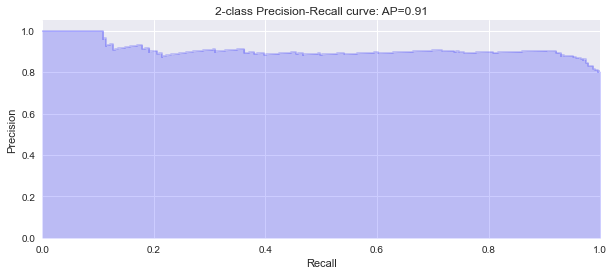

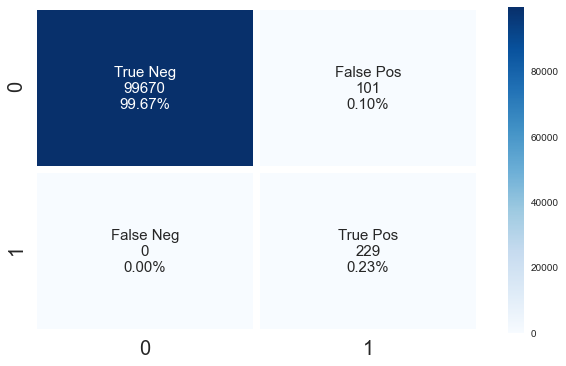

In [75]:
train_test_classification_report(pha_train_smote,
                                 grid_search_log_r_smote.best_estimator_.predict(asteroid_attributes_train_smote),
                                 pha_test, 
                                 grid_search_log_r_smote.best_estimator_.predict(asteroid_attributes_test)
                                )

plot_precision_recall_curve(grid_search_log_r_smote.best_estimator_.decision_function(asteroid_attributes_test), pha_test)
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_log_r_smote.best_estimator_.predict(asteroid_attributes_test)))

Even after the grid search the results are not improving. The overall results of the SMOTE augmented data are not what I had initially hoped for. I have saved the SMOTE variants of the data in separate variables for potential future use and testing. 




In [76]:
grid_search_log_r_smote.best_estimator_.coef_

array([[-1.04588178e+00, -1.04500073e+00, -1.04500073e+00,
         2.53613703e+00,  1.24332231e-01, -2.44238026e-01,
        -2.50695764e-02, -1.41462231e-03, -2.99443719e-02,
         2.59904053e-02,  2.04987083e-01, -3.60602276e-01,
        -1.85560013e-01, -2.17711107e-01, -2.26237312e-01,
         1.96437579e-01,  1.96437579e-01, -5.14085996e+01,
        -5.14085996e+01,  6.50081861e-02,  2.94058908e+00,
         1.43742418e+00,  1.14806126e-01,  1.54678334e-01,
        -2.57986225e+01,  1.00880264e+01, -1.30625685e+00,
         7.84554029e-02, -1.55465127e+01, -1.80023151e+00,
         5.27578536e-02, -5.48664605e+01,  6.22005931e-02,
        -9.34870560e-02,  1.01588903e+00, -7.68815719e-01,
         7.62301778e+00, -6.85280169e+00, -4.45658830e+01,
        -2.16311064e+01, -4.10450727e+00, -9.91467723e-04]])

A major downside is the increase in the time it takes to train a model using the bootstrapped data as in our case it is nearly doubled. Considering that earlier we saw several features which are good indicators of PHA, <b>Lasso</b> would have made for a good choise as na alternative to the standard Logistic regression since it allows for l2 regularization which can eliminate entire features and thus reduce training times. Another approach could be to add some more data in the form of Polynomial features which might make the class separation easier but at the expense of even more features and thus increased tarining times.


That being said I do want to move on to a more powerful model than Logistic Regression and its variations.

## 2.4 Random Forests
A much more cappable model with greater capacity consisting of many small Decision Tree classifiers. The downside is the time it may take to train. I do have a powerful PC so hopefully it will be enough.

I am picking Random Forests as it should have a easier time at defining class boundaries. 

Just like for the logistic regression I will keep the default parameters to establish a baseline.

One benefit of Random forests is that they can take advantage of multiple cores with ease as they can run a tree per core thus making the fitting much quicker than what I experienced with the logistic regression.

In [77]:
forest = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom)
forest.fit(asteroid_attributes_train, pha_train)

RandomForestClassifier(n_jobs=12, random_state=43)

#### Random Forests metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.98      1.00      0.99       229

    accuracy                           1.00    100000
   macro avg       0.99      1.00      0.99    100000
weighted avg       1.00      1.00      1.00    100000



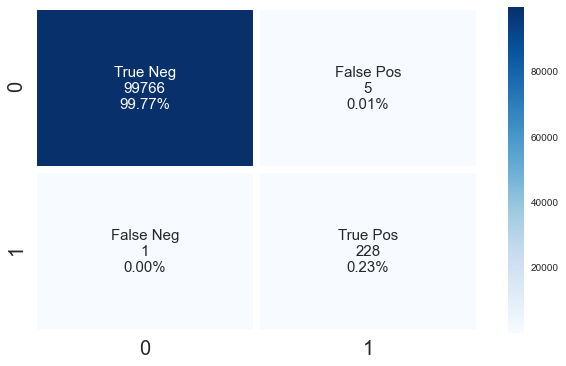

In [78]:
train_test_classification_report(pha_train_smote, 
                                 forest.predict(asteroid_attributes_train_smote),
                                 pha_test, 
                                 forest.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, forest.predict(asteroid_attributes_test)))

A huge improvement over the logistic regression. Nearly perfect scores on the test data. Random Forest is indeed much better at classifying this particular dataset.

### Forest grid search
Let's try and grab those final few percentage points of precission in a grid search. The forest recall score is already nearly perfect so I will use <b>precision</b> as the scoring metric.

First we can get an idea of the optimal parameter values by using AUC metric visualization. It can be used to see how the scores change with the change in parameter values.

Up first is n_estimators which determines the number of Decision Tree classifiers the forest is made up of.

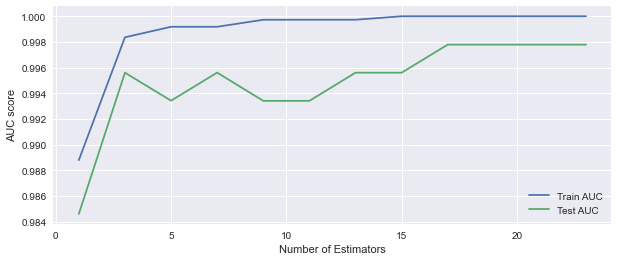

In [79]:
n_estimators = np.arange(1, 24, 2)
train_results = []
test_results = []

for estimator in n_estimators:
    dt = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom, n_estimators=estimator)
    dt.fit(asteroid_attributes_train, pha_train)
    train_pred = dt.predict(asteroid_attributes_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(pha_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    labels_pred = dt.predict(asteroid_attributes_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(pha_test, labels_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
line1, = plt.plot(n_estimators, train_results, label='Train AUC')
line2, = plt.plot(n_estimators, test_results, label='Test AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Number of Estimators')
plt.show()

The AUC plot indicates that 20 should be a good starting point for the n_estimators parameter.

Let's also plot max_depth which controls the number of branches per tree:

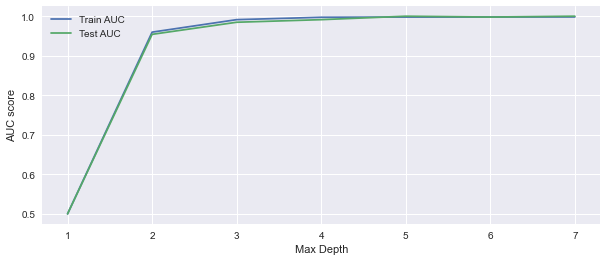

In [80]:
max_depths = np.arange(1, 8, 1)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom, max_depth=max_depth)
    dt.fit(asteroid_attributes_train, pha_train)
    train_pred = dt.predict(asteroid_attributes_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(pha_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    labels_pred = dt.predict(asteroid_attributes_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(pha_test, labels_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    
line1, = plt.plot(max_depths, train_results, label='Train AUC')
line2, = plt.plot(max_depths, test_results, label='Test AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Max Depth')
plt.show()

Seems like 5 should be a good starting point for max_depth in our grid search.

### Decision Forest grid search

The number of estimators is the most important parameter in this case because what we have been struggeling so far is falsly calssifying negative entries as positive. My hope is that there is a optimal number of estimators which will be able to define the class boundry in a very precise way.

With max _depth I want to make sure that each tree is capable of producing good results on its own otherwise its vote will not be worth much adn will even be detrimental.

In [81]:
# forest_params = {
#     "n_estimators": [50, 100, 200], #50
#     "max_depth": [20, 50, 100] #20
# }

# forest_params = {
#     "n_estimators": [30, 50], #50
#     "max_depth": [10, 20, 35] #20
# }

# grid_search_forest = GridSearchCV(
#     estimator = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom),
#     param_grid=forest_params, 
#     scoring='precision', 
#     #n_jobs=n_jobs_custom # this freezes everything...
# )
# grid_search_forest.fit(asteroid_attributes_train, pha_train)

# grid_search_forest.best_estimator_

#### Saving grid_search_forest

In [82]:
#joblib.dump(grid_search_forest, "grid_search_forest")
grid_search_forest = joblib.load("grid_search_forest")

grid_search_forest.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=12,
                       random_state=43)

#### Random Forest grid search metrics

In [83]:
train_test_classification_report(pha_train_smote, 
                                 grid_search_forest.best_estimator_.predict(asteroid_attributes_train_smote),
                                 pha_test, 
                                 grid_search_forest.best_estimator_.predict(asteroid_attributes_test)
                                )


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.98      1.00      0.99       229

    accuracy                           1.00    100000
   macro avg       0.99      1.00      0.99    100000
weighted avg       1.00      1.00      1.00    100000



No improvement in the scores but we are dealing with a very small number of values. Let's see if the confusion matrix can tell us more.

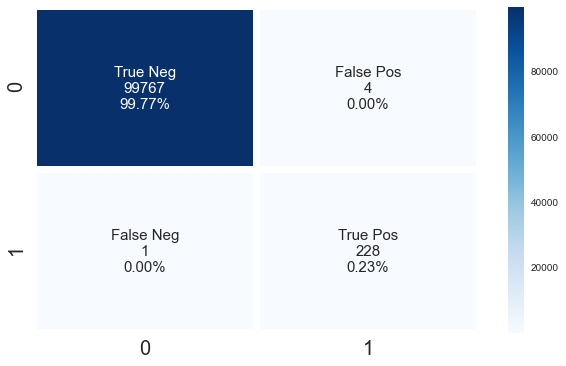

In [84]:
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_forest.predict(asteroid_attributes_test)))

A very small improvement of just a single false positive being corrected. With some more tweaks we might be able to improve the perpormance a tiny bit more or we could also try to boost the existing model as well.

<AxesSubplot:>

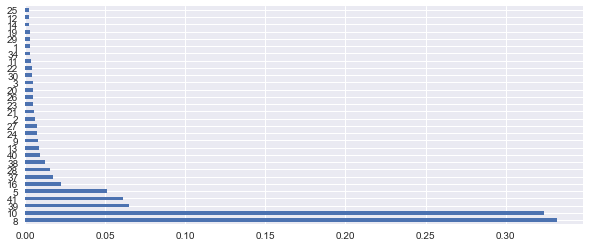

In [85]:
# Plotting feature importances

forest_indices = np.argsort(grid_search_forest.best_estimator_.feature_importances_)

(pd.Series(grid_search_forest.best_estimator_.feature_importances_, index=forest_indices)
   .nlargest(30)
   .plot(kind='barh'))

The feature importances show are rather interesting. The predictions are mostly based on two features and most features don't contribute hardly at all. Considering the size of the dataset a dimentionality reduction approach could be of use as we should be able to keep most of the information even after removing nearly half of the features.

### Testing Random Forest with SMOTE
Since we have the SMOTE data saved under separate variables let's see what results we get.

The n_jobs parameter has had a very positive effect on the training times so let us see if the SMOTE bootstrapped data will fare better with a random forest classifier.

Again keeping the default parameters to establish a baseline.

In [86]:
forest_smote = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom)
forest_smote.fit(asteroid_attributes_train_smote, pha_train_smote)

RandomForestClassifier(n_jobs=12, random_state=43)

### Random Forests SMOTE metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.96      1.00      0.98       229

    accuracy                           1.00    100000
   macro avg       0.98      1.00      0.99    100000
weighted avg       1.00      1.00      1.00    100000



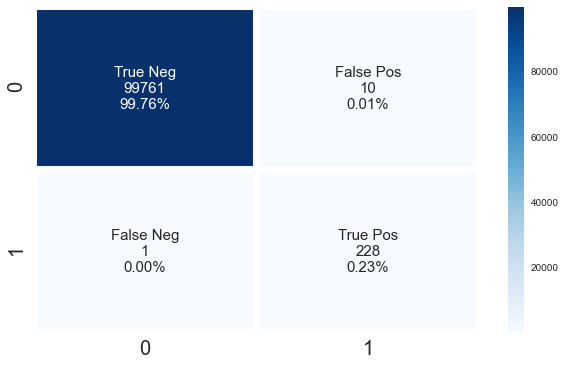

In [87]:
train_test_classification_report(pha_train_smote, 
                                 forest_smote.predict(asteroid_attributes_train_smote),                     
                                 pha_test, 
                                 forest_smote.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, forest_smote.predict(asteroid_attributes_test)))

Right off the bat we get a worse result than the default training set which is not unexpected considering we had the exact same outcome with the logistic regression.

#### Grid Search Forest SMOTE
Maybe the scores can be improved slightly by tuning the hyperparameters of the forest classifier.

In [88]:
# forest_params_smote = {
#     "n_estimators": [50, 100, 200], #50
#     "max_depth": [20, 50, 100] #50
# }

# forest_params_smote = {
#     "n_estimators": [30, 50, 70], #50
#     "max_depth": [30, 50, 70] #50
# }

# grid_search_forest_smote = GridSearchCV(
#     estimator = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom),
#     param_grid=forest_params_smote, 
#     scoring='precision', 
#     #n_jobs=n_jobs_custom  # freezes everything - don't use!
# )
# grid_search_forest_smote.fit(asteroid_attributes_train_smote, pha_train_smote)

# grid_search_forest_smote.best_estimator_

#### Saving grid_search_forest_smote

In [89]:
#joblib.dump(grid_search_forest_smote, "grid_search_forest_smote")
grid_search_forest_smote = joblib.load("grid_search_forest_smote")

grid_search_forest_smote.best_estimator_

RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=12,
                       random_state=43)

#### Random Forests SMOTE grid search metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00    801150

    accuracy                           1.00   1602300
   macro avg       1.00      1.00      1.00   1602300
weighted avg       1.00      1.00      1.00   1602300


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.95      1.00      0.97       229

    accuracy                           1.00    100000
   macro avg       0.98      1.00      0.99    100000
weighted avg       1.00      1.00      1.00    100000



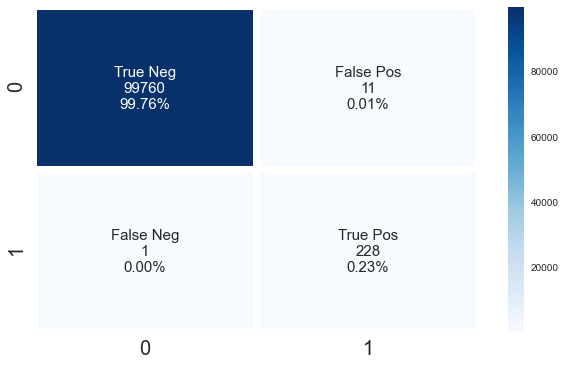

In [90]:
train_test_classification_report(pha_train_smote, 
                                 grid_search_forest_smote.best_estimator_.predict(asteroid_attributes_train_smote),
                                 pha_test, 
                                 grid_search_forest_smote.best_estimator_.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_forest_smote.predict(asteroid_attributes_test)))

Much like the in the case of the Logistic Regression, Random Forest has not benefited from the SMOTE data and at this point I will just stick to the regular data as that has proven to be more accurate.

<AxesSubplot:>

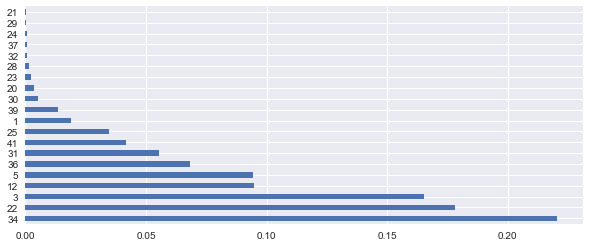

In [91]:
# Plotting Random Forests SMOTE grid search feature importances

grid_search_forest_smote_indecies = np.argsort(grid_search_forest_smote.best_estimator_.feature_importances_)

(pd.Series(grid_search_forest_smote.best_estimator_.feature_importances_, index=grid_search_forest_smote_indecies)
   .nlargest(20)
   .plot(kind='barh'))

Feature importances for the SMOTE data show similar tendencies as the non bootstrapped data but with even less features being of any real significance. A definate kandidate for dimentionality reduction.

## 2.5 PCA
Principal component analysis (PCA) applies a linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. It should remove noise and missleading data by reducing the number of features and thus improve the training speed with almost no cost to accuracy or in some cases also improve accuracy due to the reduction in noise.

In [92]:
# Setting up and fitting PCA

pca = PCA(random_state=43)
pca.fit(asteroid_attributes_train)

PCA(random_state=43)

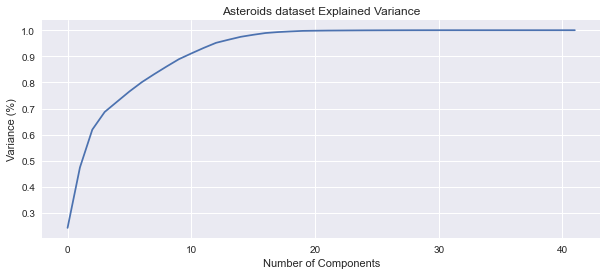

In [93]:
# Plotting the Cumulative Summation of the Explained Variance

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Asteroids dataset Explained Variance')
plt.show()

The explained variance plot is showing that we can keep almost all of the data varance with just 18 or so features. Let's use a 99% variance threshold which should leave us with just under 20 features.

In [94]:
# Fitting the adjusted algorith to the train data

pca = PCA(n_components=0.99 , random_state=43)
pca.fit(asteroid_attributes_train)

PCA(n_components=0.99, random_state=43)

In [95]:
# Transforming both the train and test sets

asteroid_attributes_train_pca = pca.transform(asteroid_attributes_train)
asteroid_attributes_test_pca = pca.transform(asteroid_attributes_test)

In [96]:
asteroid_attributes_train.shape

(802987, 42)

In [97]:
asteroid_attributes_train_pca.shape

(802987, 18)

In [98]:
asteroid_attributes_test.shape

(100000, 42)

In [99]:
asteroid_attributes_test_pca.shape

(100000, 18)

We are indeed left with just 18 features.

### 2.5.1 PCA Forest
Time to test if PCA has had the desired effect. Let's use Random Forests as that is our best algorithm currently.

In [100]:
# Fitting the Forest classifier to the PCA data

forest_pca = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom, max_depth=20, n_estimators=50)
forest_pca.fit(asteroid_attributes_train_pca, pha_train)

RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=12,
                       random_state=43)


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00      1837

    accuracy                           1.00    802987
   macro avg       1.00      1.00      1.00    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.67      0.33      0.44       229

    accuracy                           1.00    100000
   macro avg       0.84      0.67      0.72    100000
weighted avg       1.00      1.00      1.00    100000



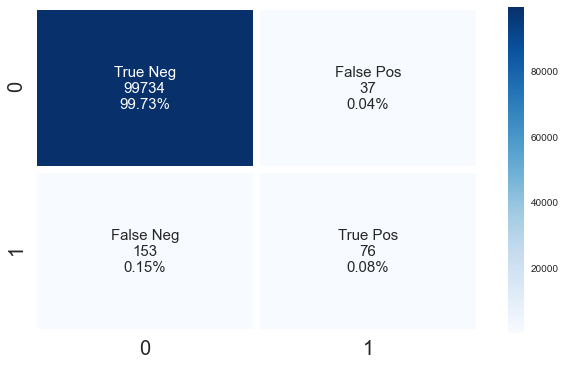

In [101]:
# Metrics

train_test_classification_report(pha_train, 
                                 forest_pca.predict(asteroid_attributes_train_pca),
                                 pha_test, 
                                 forest_pca.predict(asteroid_attributes_test_pca)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, forest_pca.predict(asteroid_attributes_test_pca)))

Very underwhelming results unfortunately. For some reason PCA reduced the model's skill drastically.

With the reduced dimentions a cross validation should not take all that long so let's give it a shot.

<AxesSubplot:>

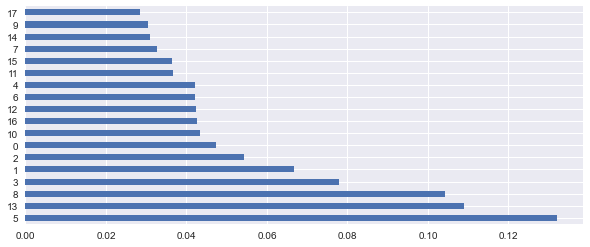

In [102]:
forest_pca.feature_importances_

forest_pca_indices = np.argsort(forest_pca.feature_importances_)

(pd.Series(forest_pca.feature_importances_, index=forest_pca_indices)
   .nlargest(21)
   .plot(kind='barh'))

Feature importances indeed are much more balanced now. Unfortunately the algorithm does not seem to be getting as much information as it should have.

#### Grid Search Forest PCA
I attempted to optimize the Random Forest with the PCA data but it seemed that the search was not progressing and i interrupted it after a couple of hours.

Considering the poor results we received on the baseline run I don't believe we will get much out of this data so I will proceed without it.

In [103]:
# Random forest PCA parameter optimization

# forest_pca_params = {
#     "n_estimators": [50, 100, 200],
#     "max_depth": [20, 50, 100]
# }

# grid_search_forest_pca = GridSearchCV(
#     estimator = RandomForestClassifier(random_state=43n n_jobs=43),
#     param_grid=forest_pca_params,
#     scoring='f1'
# )
                                      
# grid_search_forest_pca.fit(asteroid_attributes_train_pca, pha_train)

In [104]:
#grid_search_forest_pca.best_estimator_,

#print(classification_report(pha_train, grid_search_forest_pca.best_estimator_.predict(asteroid_attributes_train_pca))),
#print(classification_report(pha_test, grid_search_forest_pca.best_estimator_.predict(asteroid_attributes_test_pca))),

#grid_search_forest_pca.best_estimator_.feature_importances_

#grid_search_forest_pca_indices = np.argsort(grid_search_forest_pca.best_estimator_.feature_importances_)

#(pd.Series(grid_search_forest_pca.best_estimator_.feature_importances_, index=grid_search_forest_pca_indices)
#   .nlargest(15)
#   .plot(kind='barh'))

### PCA with SMOTE

Let's see if the the SMOTE data will fare any better.

In [105]:
# Training PCA on the SMOTE data

pca_smote = PCA(random_state=43)
pca_smote.fit(asteroid_attributes_train_smote)

PCA(random_state=43)

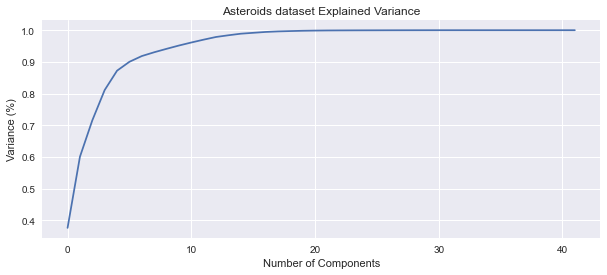

In [106]:
# Plotting the Cumulative Summation of the Explained Variance

plt.figure()
plt.plot(np.cumsum(pca_smote.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Asteroids dataset Explained Variance')
plt.show()

Judging by the plot we should be able to keep nearly all of the variance in the data with just 20 or so features.
As we saw previously in forest section, the feature importance of the SMOTE data is concentrated in fewer features when compared to the non SMOTE data and as a result we are able to take less features but keep the same level of variance.

Considering how underwhelming the results from the non bootstrapped PCA run were my expectations are not that high here either but perhaps we can get some insight into the data itself.


PCA will likely use separate logic when reducing dimentionality for the bootstrapped and non bootstrapped data so I will transform the test features once again and keep them in a separate variable.

In [107]:
# Trainsforming the SMOTE train and test data 

pca_smote = PCA(n_components=0.99, random_state=43)
asteroid_attributes_train_smote_pca = pca_smote.fit_transform(asteroid_attributes_train_smote)
asteroid_attributes_test_smote_pca = pca_smote.transform(asteroid_attributes_test)

In [108]:
asteroid_attributes_train_smote.shape

(1602300, 42)

In [109]:
asteroid_attributes_train_smote_pca.shape

(1602300, 16)

In [110]:
asteroid_attributes_test_smote_pca.shape

(100000, 16)

Two less features used in the bootstrapped PCA at the same explained variance threshold which is consistent with our finding from earlier.

### 2.5.2 PCA Forest with SMOTE
Let's test and see if the bootstrapped PCA will have more success

In [111]:
# Fitting the Random Forest to the SMOTE PCA data

forest_pca_smote = RandomForestClassifier(max_depth=50, n_estimators=100, random_state=43, n_jobs=n_jobs_custom)
forest_pca_smote.fit(asteroid_attributes_train_smote_pca, pha_train_smote)

RandomForestClassifier(max_depth=50, n_jobs=12, random_state=43)

In [112]:
print(classification_report(pha_test, forest_pca_smote.predict(asteroid_attributes_test_smote_pca)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.34      0.95      0.50       229

    accuracy                           1.00    100000
   macro avg       0.67      0.97      0.75    100000
weighted avg       1.00      1.00      1.00    100000



Much like the Logistic Regression, the forest PCA SMOTE gains recall at the expense of precision.

<AxesSubplot:>

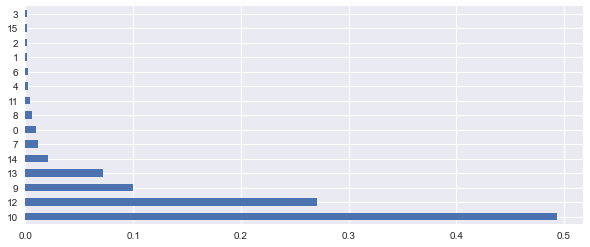

In [113]:
# Plotting feature importances

forest_pca_smote.feature_importances_

forest_pca_smote_indices = np.argsort(forest_pca_smote.feature_importances_)

(pd.Series(forest_pca_smote.feature_importances_, index=forest_pca_smote_indices)
   .nlargest(15)
   .plot(kind='barh'))

Feature importances are now rather imbalanced.

The PCA testing did not yeald much of use unfortunately.

The data is available in separate variables for future testing. Let's move on to the next step.

### 2.5.3 PCA revalations

I am realizing a bit too late that I fit a non linear dataset to a PCA with no kernel. The initial plan was to use a kernel but unfortunately the dataset was way too large and my RAM was not sufficient. I fit it without the kernel and got carried away. The dimentionality reduction section of this project will need to be revisited with a different approach.


## 2.6 AdaBoost

Let's see if we can boost our models with Adaptive Boosting. It combines multiple classifiers to increase their accuracy. AdaBoost is an iterative ensemble method which builds a strong classifier by combining multiple poorly performing classifiers. 





### 2.6.1 AdaBoost Random Forests

Let's start with Random Forests and its tuned hyperparameters.

In [114]:
ada_boost_forest = AdaBoostClassifier(base_estimator = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom), random_state=43)
ada_boost_forest.fit(asteroid_attributes_train, pha_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs=12,
                                                         random_state=43),
                   random_state=43)

#### AdaBoost Forest metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00      1837

    accuracy                           1.00    802987
   macro avg       1.00      1.00      1.00    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.98      0.99      0.98       229

    accuracy                           1.00    100000
   macro avg       0.99      0.99      0.99    100000
weighted avg       1.00      1.00      1.00    100000



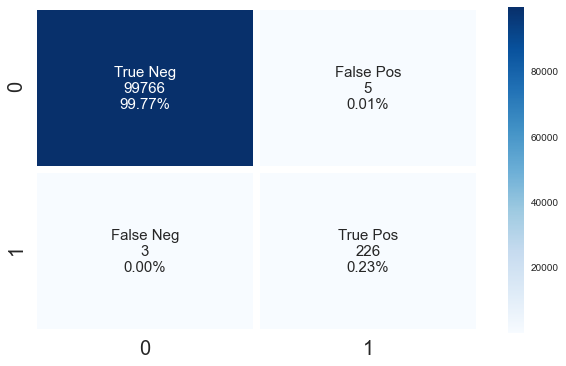

In [115]:
train_test_classification_report(pha_train, 
                                 ada_boost_forest.predict(asteroid_attributes_train),
                                 pha_test, 
                                 ada_boost_forest.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, ada_boost_forest.predict(asteroid_attributes_test)))

Our scores are slightly lower than the best forest so let's try and play around with the number of estimators.

### 2.6.2 AdaBoost Forest parameter optimization

I am only realy interested in the number of estimators as i would like to see if multiple forests will prove more reliable.

In [116]:
# ada_boost_params = {#'base_estimator__n_estimators': [50, 100, 200], #50
#                     #'base_estimator__max_depth': [10, 20, 50, 100], #20
#                     'n_estimators':[1, 2, 5, 10], # 1
#                     #'learning_rate':[0.000001, 0.00001, 0.0001] # 0.000001
#                    }

# grid_search_ada_boost = GridSearchCV(
#     estimator = AdaBoostClassifier(base_estimator = RandomForestClassifier(random_state=43, n_jobs=n_jobs_custom, max_depth=20, n_estimators=50), random_state=43), 
#     param_grid = ada_boost_params, 
#     scoring = 'f1')
# grid_search_ada_boost.fit(asteroid_attributes_train, pha_train)  
# grid_search_ada_boost.best_estimator_

#### Saving AdaBoost forest

In [117]:
#joblib.dump(grid_search_ada_boost, "grid_search_ada_boost")
grid_search_ada_boost_forest = joblib.load("grid_search_ada_boost")

grid_search_ada_boost_forest.best_estimator_

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=20,
                                                         n_estimators=50,
                                                         n_jobs=12,
                                                         random_state=43),
                   n_estimators=1, random_state=43)

The best estimators from the grid search are telling me that one estimator is all I need. Appears that multiple forests do not produce a better result at least with the current hyperparameter setup.

#### AdaBoost Forest grid search metrics


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       1.00      1.00      1.00      1837

    accuracy                           1.00    802987
   macro avg       1.00      1.00      1.00    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.97      0.99      0.98       229

    accuracy                           1.00    100000
   macro avg       0.98      0.99      0.99    100000
weighted avg       1.00      1.00      1.00    100000



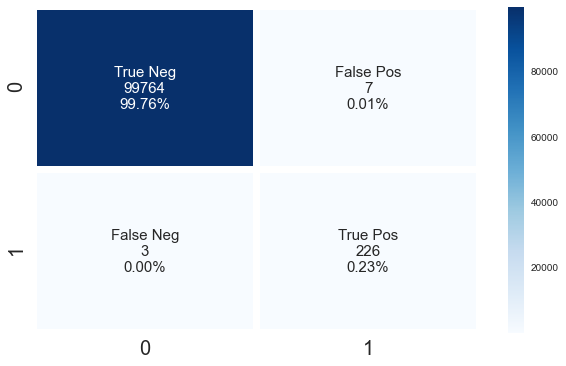

In [118]:
train_test_classification_report(pha_train, 
                                 grid_search_ada_boost_forest.best_estimator_.predict(asteroid_attributes_train),
                                 pha_test, 
                                 grid_search_ada_boost_forest.best_estimator_.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_ada_boost_forest.best_estimator_.predict(asteroid_attributes_test)))

Again slightly worse than the Random Forests. Seems like AdaBoost with forests is not the way to go.

### 2.6.3 AdaBoost Logistic Regression

Logistic Regression should fare much better than boosted Random Forests. Since it's a much simpler algorithm, logistic regression will benefit from having multiple instances and should improve calss boundries identification.

Let's try to boost a Logistic Regression using our best parameters from the earlier optimization. 

In [119]:
ada_boost_log_r = AdaBoostClassifier(base_estimator = LogisticRegression(random_state=43, C=50, max_iter=700), random_state=43)
ada_boost_log_r.fit(asteroid_attributes_train, pha_train)

AdaBoostClassifier(base_estimator=LogisticRegression(C=50, max_iter=700,
                                                     random_state=43),
                   random_state=43)


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       0.87      0.84      0.85      1837

    accuracy                           1.00    802987
   macro avg       0.93      0.92      0.93    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.88      0.86      0.87       229

    accuracy                           1.00    100000
   macro avg       0.94      0.93      0.94    100000
weighted avg       1.00      1.00      1.00    100000



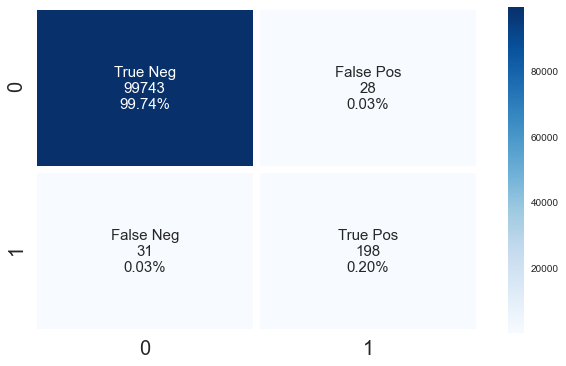

In [120]:
train_test_classification_report(pha_train, 
                                 ada_boost_log_r.predict(asteroid_attributes_train),
                                 pha_test, 
                                 ada_boost_log_r.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, ada_boost_log_r.predict(asteroid_attributes_test)))

A sizeable improvement over the base logistic regression. Both precision and recall have been bumped up. Let's try and  optimize the number of estimators.

### 2.6.4 AdaBoost Logistic Regression grid search
A higher number of logistic regressions should be better at identifiyng class boundries so again I will only tune the n_estimators parameter.

In [121]:
# ada_boost_params = {#'base_estimator__max_depth':[i for i in range(2,11,2)],
#                     #'base_estimator__min_samples_leaf':[5,10],
#                     'n_estimators':[10, 15, 20],
#                     #'learning_rate':[0.0001, 0.001]
#                    }

# grid_search_ada_boost_log_r = GridSearchCV(
#     estimator = AdaBoostClassifier(base_estimator = LogisticRegression(random_state=43, C=50, max_iter=700), random_state=43), 
#     param_grid = ada_boost_params, 
#     scoring = 'f1',
#     n_jobs=n_jobs_custom
# )
# grid_search_ada_boost_log_r.fit(asteroid_attributes_train, pha_train)  
# grid_search_ada_boost_log_r.best_estimator_

#### Saving AdaBoost Logistic Regression

In [122]:
#joblib.dump(grid_search_ada_boost_log_r, "grid_search_ada_boost_log_r")
grid_search_ada_boost_log_r = joblib.load("grid_search_ada_boost_log_r")

grid_search_ada_boost_log_r.best_estimator_

AdaBoostClassifier(base_estimator=LogisticRegression(C=50, max_iter=700,
                                                     random_state=43),
                   n_estimators=15, random_state=43)


--------------------  Train set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    801150
           1       0.86      0.85      0.85      1837

    accuracy                           1.00    802987
   macro avg       0.93      0.92      0.93    802987
weighted avg       1.00      1.00      1.00    802987


--------------------  Test set scores  --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99771
           1       0.86      0.86      0.86       229

    accuracy                           1.00    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       1.00      1.00      1.00    100000



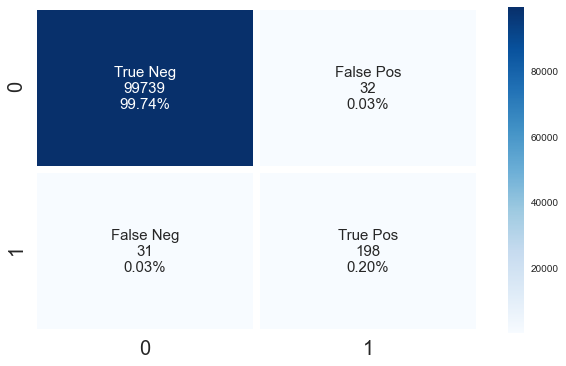

In [123]:
train_test_classification_report(pha_train, 
                                 grid_search_ada_boost_log_r.best_estimator_.predict(asteroid_attributes_train),
                                 pha_test, 
                                 grid_search_ada_boost_log_r.best_estimator_.predict(asteroid_attributes_test)
                                )
plot_confusion_matrix(confusion_matrix(pha_test, grid_search_ada_boost_log_r.best_estimator_.predict(asteroid_attributes_test)))

Not much has changed from the baseline version of AdaBoost with Logistic Regression.

In the end by using AdaBoost we did manage to get a sizeable increase in the score of the logistic regression.

## 3. Model comparison

Finally let's compare the performance of all models. Considering the imbalance in the classes and the general tendencies of models to not struggle with recall let's use precision as our main scoring metric.

In [124]:
grid_search_log_r_score = precision_score(pha_test, grid_search_log_r.best_estimator_.predict(asteroid_attributes_test))
grid_search_forest_score = precision_score(pha_test, grid_search_forest.best_estimator_.predict(asteroid_attributes_test))
grid_search_ada_boost_log_r_score = precision_score(pha_test, grid_search_ada_boost_log_r.best_estimator_.predict(asteroid_attributes_test))
grid_search_ada_boost_forest_score = precision_score(pha_test, grid_search_ada_boost_forest.best_estimator_.predict(asteroid_attributes_test))

print("Logistic regression precision score:", grid_search_log_r_score)
print("Random Forests precision score:", grid_search_forest_score)
print("Adaboost Logistic Regression precision score:", grid_search_ada_boost_log_r_score)
print("Adaboost Random Forests precision score:", grid_search_ada_boost_forest_score)

Logistic regression precision score: 0.864406779661017
Random Forests precision score: 0.9827586206896551
Adaboost Logistic Regression precision score: 0.8608695652173913
Adaboost Random Forests precision score: 0.9699570815450643


The Random Forests calssifier comes out on top with a score of 98% precision.



In [125]:
grid_search_log_r_score = recall_score(pha_test, grid_search_log_r.best_estimator_.predict(asteroid_attributes_test))
grid_search_forest_score = recall_score(pha_test, grid_search_forest.best_estimator_.predict(asteroid_attributes_test))
grid_search_ada_boost_log_r_score = recall_score(pha_test, grid_search_ada_boost_log_r.best_estimator_.predict(asteroid_attributes_test))
grid_search_ada_boost_forest_score = recall_score(pha_test, grid_search_ada_boost_forest.best_estimator_.predict(asteroid_attributes_test))

print("Logistic regression recall score:", grid_search_log_r_score)
print("Random Forests recall score:", grid_search_forest_score)
print("Adaboost Logistic Regression recall score:", grid_search_ada_boost_log_r_score)
print("Adaboost Random Forests recall score:", grid_search_ada_boost_forest_score)

Logistic regression recall score: 0.8908296943231441
Random Forests recall score: 0.9956331877729258
Adaboost Logistic Regression recall score: 0.8646288209606987
Adaboost Random Forests recall score: 0.9868995633187773


And for the recall score Random Forests is leading again with almost 100%.

## 4. Clustering and data visualizations using TSNE and K-Menas

As a final step let's try to visualize the data to try and get some insight into the dataset and the results from this research. To reduce the time spent on training I will just use 1/3 of the available data.

In [126]:
# Reducing number of observations to improve trainig time
asteroid_attributes_scaled_clustering = asteroid_attributes_scaled[:300000]

In [127]:
# # Setting up and fitting TSNE

# tsne = TSNE(n_components=2,init='pca',verbose=1,metric='euclidean', perplexity=40)
# tsne_results = tsne.fit_transform(asteroid_attributes_scaled[:300000])

#### Saving TSNE
Saving the trained TSNE model as it is quite slow to run.

In [128]:
#joblib.dump(tsne_results, "tsne_results")
tsne_results = joblib.load("tsne_results")

### 4.1 Plotting the data
Let's plot the TSNE results.

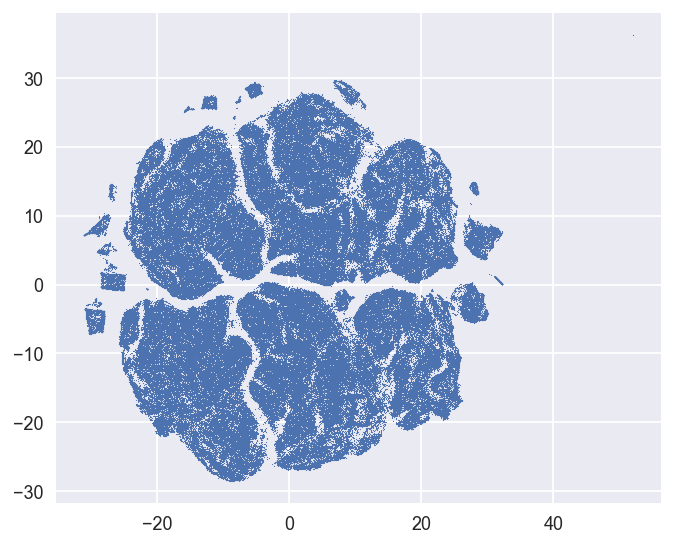

In [129]:
# Plot a scatter plot from the generated t-SNE results
plt.figure(figsize=(6, 5), dpi=130)
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], s=0.1)
plt.show()

Looks like we do have some separation in the data. There are some small clusters on the outside of the plot some of which might correspond to our positive PHA or NEO entries. Still with the low number of positive values for those two features it is very likely that they won't be easily visible on such a plot considering the total number of observations.

There is also one (or more) barely visible observation on the top right of the plot which does indicate that we have a slight outlier issue. 



### 4.2 Inertia
To determine the optimal number of clusters we can use KMenas. By cycling through a number of cluster values and plotting their inertia we can find the optimal number of clusters for the given dataset.

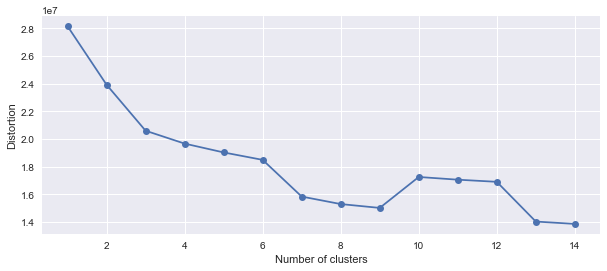

In [130]:
# Plot cluster inertia

distortions = []

for i in range(1, 15):
    km = KMeans(
        n_clusters = i, init = 'random', random_state = 43, n_jobs=n_jobs_custom
    )
    km.fit(asteroid_attributes_scaled)
    distortions.append(km.inertia_)
    
# Plot
plt.plot(range(1, 15), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

We can see that with 7 clusters we will have reduced the inertia significantly. Increasing the number of clusters will not result in a significant improvement.

### 4.3 Plotting the clusters
Let's use 7 as our cluster value.

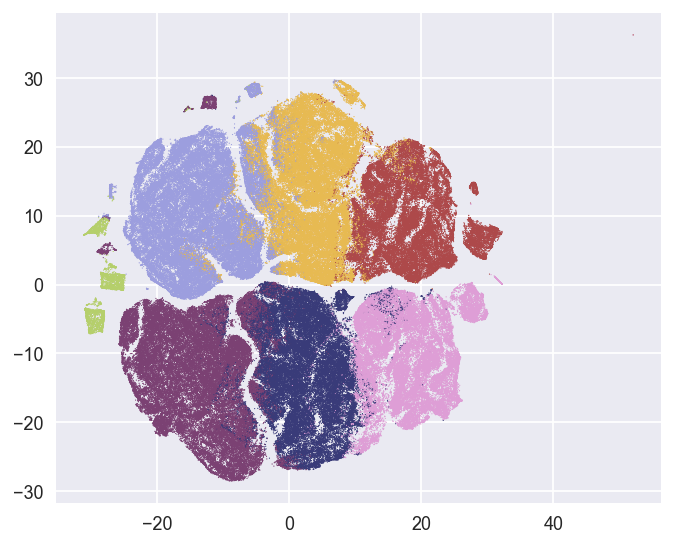

In [131]:
k_means = KMeans(n_clusters=7, random_state=43, init = 'random', max_iter=1000, n_jobs=n_jobs_custom)
k_means.fit(asteroid_attributes_scaled_clustering)
plt.figure(figsize=(6, 5), dpi=130)
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=k_means.labels_, cmap='tab20b', alpha=1.0, s=0.1)

The clusters are somewhat well separted but we do have a few significant crossovers between the four largest ones.

The cluster which is of most interest to me is the green one to the left of the plot. Due to it's size it might be the one encompassing our positive PHA and NEO values.

It does seem that clustering might be a feasable approach for this dataset but considering I have not been able to plot it in its entireity I cannot have much confidence in the accuracy of this representation. Additionally the dataset I have used for this visualization does not contain the PHA flag so I will leave this here and improve upon it at a later point.

## Summary

The goal of this project was to predict if an asteroid is hazardous using the PHA flag in NASA's JLP Asteroid Dataset. 

In the process we implemented a number of techniques. From the realm of preprocessing we utilized some feature engineering,  bootstrapping via KNN (SMOTE) and Principal Component Anlysis (PCA). Several calssification algorithms were also implemented the performance of which was successfully improved by tuning their respective hyperparameters. 

The PCA results were so low compared to the base ones that I did not want to invest any more time into it. It doesn't seem to be working properly with the way I have it set up currently.

SMOTE results were not much better than PCA. It is worth pointing out that I implemented the SMOTE bootstrapping before cleaning up the outliers. When the outliers were still in SMOTE actually was a great help and more than doubled the f1 score for the logistic regression (from 30 to aroud 60 which was still not all that great) and also improved the fores calssifier as well. After cleaning up the outliers the scores on the non bootstrapped data jumped to their current levels.

As a possible improvement some more tweaking of the Random Forest Classifier parameters would likely improve the results as this project only covered <b>n_estimators</b> and <b>max_depth</b>. Tweaking class weights is also worth looking into.

Considering the nature of the dataset and how the positive PHA values are exibiting very outlier like behaviour, a good next step would be to train a Support Vector Classsifier. Due to the time investment needed to implement an SVM on a dataset of this size I will not be attemting it in this project.

## References


- Kaggle dataset - [NASA's JLP Asteroid Dataset](https://www.kaggle.com/sakhawat18/asteroid-dataset).
- [Sci-Kit Learn](https://scikit-learn.org/stable/)
- [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) by Jason Bwonlee
- [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) by Will Koehrsen
- [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [Codebasics](https://www.youtube.com/channel/UCh9nVJoWXmFb7sLApWGcLPQ)